#### Importando as bibliotecas

In [247]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

from BaselineRemoval import BaselineRemoval

from matplotlib.pyplot import figure

from scipy.signal import find_peaks, savgol_filter
from scipy.stats import norm

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import OneClassSVM

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

#### Definindo as funções

1. Importação dos dados e organização em um _dataframe_
* ##### `dataframe(path)`
Todos os arquivos do diretório (definido no parâmetro de entrada `path`) com terminação `.txt` são listados. O conteúdo desses arquivos é agrupado em um _dataframe_ com base na coluna `numero de onda`. Uma nova coluna para a intensidade medida em um número de onda, nomeada como `espectro[0-9][0-9][0-9][0-9]`, é adicionada a cada iteração.

In [3]:
def dataframe(path):
    holding = {}
    files = os.listdir(path)
    for file in files:
        if file.endswith('.txt'):
            file_path = f"{path}/{file}"
            holding[file] = pd.read_csv(file_path, sep="\t", header=None)
            holding[file].columns = ['numero de onda', 'espectro' + f'{int(file[0:3]):04d}']
            if file == files[0]:
                holding[file]
            else:
                holding[files[0]] = pd.merge(holding[files[0]], holding[file], how='inner', on='numero de onda')
    df = holding[files[0]]
    
    return df

* ##### `dataframe_mapping(path)`
Todos os arquivos do diretório (definido no parâmetro de entrada `path`) com terminação `[1-2].txt` são listados. O conteúdo desses arquivos é agrupado em um _dataframe_.

In [4]:
def dataframe_mapping(path, n):
    holding = {}
    i = 0
    j = 1
    files = sorted(os.listdir(path))
    for file in files:
        if file.endswith('[{}].txt'.format(n)):
            file_path = f"{path}/{file}"
            holding[file] = pd.read_csv(file_path, header=None)
            if file.startswith('X'):
                df = pd.DataFrame(holding[file].values, columns = ['numero de onda'])
            if file.startswith('Y'):
                while j <= holding[file].shape[0]/1600:
                    if j == 1:
                        df['espectro%04d' % j] = holding[file][i:1600*j]
                    else:
                        temp = holding[file][i:1600*j]
                        temp.reset_index(inplace=True, drop=True)
                        df['espectro%04d' % j] = temp
                    i += 1600
                    j += 1
    
    return df

2. Ajuste do intervalo de números de onda
##### `adjust_wavenumber(df)`
Todos os valores da coluna `numero de onda` são arredondados e armazenados em uma nova coluna `round`. Valores inferiores a 700 cm$^{-1}$ e superiores a 1699 cm$^{-1}$ são desconsiderados.

In [5]:
def adjust_wavenumber(df, w1, w2):
    df['round'] = df['numero de onda'].round(0)
    mask = (df['round'] < w1) | (df['round'] > w2)
    df = df.loc[~mask]
    df.reset_index(drop=True, inplace=True)
    
    return df

3. Pré-processamento
* ##### `normalize(data_input)`
A normalização é feita por meio da função de escalonamento mı́nimo-máximo de recursos, que restringe o intervalo de valores entre os pontos arbitrários a e b (no caso, [0,1]).

In [6]:
def normalize(data_input):
    return (data_input - data_input.min()) / (data_input.max() - data_input.min())

* ##### `preprocess(df)` e `preprocess_add(df)`
O pré-processamento consiste na correção da linha de base com o método `IModPoly` e suavização dos espectros por meio do método de Savitzky-Golay, implementado no método `savgol_filter`.

In [7]:
def preprocess(df):
    for columns in df:
        if columns.startswith('espectro'):
            df[columns] = df[columns] - df[columns].min()
            base = BaselineRemoval(df[columns])
            polynomial_degree = 5
            df[columns + 'bl'] = base.IModPoly(polynomial_degree)
            df[columns + 'sg'] = savgol_filter(df[columns + 'bl'], window_length=21, polyorder=2)
    
    return df

In [8]:
def preprocess_add(df):
    for columns in df:
        if columns.startswith('espectro'):
            df[columns] = df[columns] - df[columns].min()
            base = BaselineRemoval(df[columns])
            polynomial_degree = 5
            df[columns + 'bl'] = base.IModPoly(polynomial_degree)
            df[columns + 'sg'] = savgol_filter(df[columns + 'bl'], window_length=41, polyorder=2)
    
    return df

* ##### `preprocess_wnorm(df, df_output)`
O pré-processamento consiste na correção da linha de base com o método `IModPoly`, normalização com a função `normalize` e suavização dos espectros por meio do método de Savitzky-Golay, implementado no método `savgol_filter`.

In [9]:
def preprocess_wnorm(df, df_output):
    df_output = df
    for columns in df:
        if columns.endswith('sg'):
            df_output[columns[0:12] + 'norm'] = normalize(df[columns])
    
    return df_output

4. Execução do ajuste do intervalo de números de onda  e pré-processamento
* ##### `execute(df)` e `execute_wplot(df)`
O intervalo dos espectros contidos no _dataframe_ é ajustado para os valores definidos na função `adjust_wavenumber`, assim como os espectros são pré-processados conforme as etapas de pré-processamento. 

In [10]:
def execute(df, w1, w2):
    df = adjust_wavenumber(df, w1, w2)
    df = preprocess(df)
    plot(df, 'sg')
    
    return df

In [11]:
def execute_wplot(df, w1, w2):
    df = adjust_wavenumber(df, w1, w2)
    df = preprocess(df)
    
    return df

5. Exibição de espectros interativos
##### `plot(df)`
Todos os espectros são exibidos de modo interativo, sendo possível ocultá-los ou apresentá-los, ou obter as coordenadas de pontos específicos.

In [12]:
def plot(df, pp):
    lst = []
    for columns in df:
        if columns.endswith(pp):
            regex = 'espectro([0-9]*)'
            match = re.search(regex, columns)
            
            if match:
                lst.append(go.Scatter(x=list(df['numero de onda']), 
                                      y=list(df[columns]), 
                                      mode='lines', 
                                      name=match.group(1)))

    fig = go.Figure(data=lst)
    py.iplot(fig)

6. Reorganização do conjunto de dados
* ##### `preprocessed_dataframe_norm(df_input)`
O conjunto de dados pré-processados foi transposto para que os dados das linhas sejam movidos para as colunas e vice-versa. Ou seja, cada linha representa um espectro e cada coluna representa a intensidade medida em um número de onda.

In [13]:
def preprocessed_dataframe(df_input, pp):
    df_output = pd.DataFrame()
    df_output['numero de onda'] = df_input['numero de onda']
    for columns in df_input:
        if columns.endswith(pp):
            df_output[columns] = df_input[columns]
    df_output.set_index('numero de onda', inplace=True)
    df_output = df_output.transpose()
    
    return df_output

* ##### `preprocessed_dataframes(df_input, df_output)`
Todos os conjuntos de dados pré-processados são agrupados e transpostos para que os dados das linhas sejam movidos para as colunas e vice-versa. Ou seja, cada linha representa um espectro e cada coluna representa a intensidade medida em um número de onda.

In [14]:
def preprocessed_dataframes(df_input, df_output, pp):
    for columns in df_input:
        if columns.endswith(pp):
            regex = 'df(.+?)[e0-9]_\S*_120min_(.+?)_([0-9]?)\S*$'
            match = re.search(regex, df_input.name)
            
            if match:
                um = match.group(1)
                dois = match.group(2)
                tres = match.group(3)
            
            df_output[dois + columns + um + tres] = df_input[columns]
    
    return df_output

7. Definição dos rótulos de classe
##### `create_label(df_input, df_output, c, molecule)` e `create_label_spectrum(df, c, molecule)` 
Os rótulos de classe atribuídos para cada um dos espectros de MB, R6G e da mistura.

In [15]:
def create_label(df_input, df_output, c, molecule, pp):
    for columns in df_input:
        for index, row in df_output.iterrows():
            regex = '[0-9]{{2}}(.+?){}(\S*)'.format(pp)
            match = re.search(regex, index)

            if match != None and molecule == match.group(2):
                if match.group(1) == columns:
                    df_output['label'][index] = c
    
    return df_output

In [16]:
def create_label_spectrum(df, c, molecule, spectra, pp):
    for index, row in df.iterrows():
        regex = "[0-9]{{2}}(.+?)([0-9]*){}(\S*)".format(pp)
        match = re.search(regex, index)

        if match != None and molecule == match.group(3):
            for spectrum in spectra:
                if spectrum == match.group(2):
                    df['label'][index] = c
    return df

8. Visualização pós _PCA_
* ##### `plot_pca(df_input, df_output, c)`

In [17]:
def plot_pca(df, X, explained_variance, frame, labelPlot, colors):
    figure(figsize=(4, 6), dpi=300)
    unique = list(set(df['label']))

    var1 = explained_variance[0]
    var2 = explained_variance[1]

    with plt.style.context(('grayscale')):
        for i, u in enumerate(unique):
            col = np.expand_dims(np.array(colors[i]), axis=0)
            xi = [X[j,0] for j in range(len(X[:,0])) if df['label'][j] == u]
            yi = [X[j,1] for j in range(len(X[:,1])) if df['label'][j] == u]

            plt.scatter(xi, yi, c=col, s=60, edgecolors='k', label=(u))

        plt.xlabel('PC\u2081' + f' ({var1:.2%})')
        plt.ylabel('PC\u2082' + f' ({var2:.2%})')
        plt.legend(labelPlot, loc='upper right')
        
        if frame == False:
            plt.gca().get_legend().remove()
            
        plt.show()

* ##### `plot_loadings(df, n)` e `plot_n_loadings`

In [18]:
def plot_loadings(df, npca, PC):
    fig = plt.figure(figsize=(4, 4), dpi=600)
    loadings = npca.components_.T * np.sqrt(npca.explained_variance_)
    df_loading = pd.DataFrame(loadings[0:1495], columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6'], index=df['numero de onda'])

    plt.plot(df['numero de onda'], df_loading[PC], color='black', linewidth=1)

    plt.xlabel('Deslocamento Raman (cm$^{-1}$)')
    plt.ylabel('Pesos do PC\u2081')

In [19]:
def plot_n_loadings(df, npca, n, mb, r6g):
    fig = plt.figure(figsize=(4, 20), dpi=600)
    pcs = []
    loadings = npca.components_.T * np.sqrt(npca.explained_variance_)

    for i in range(1, n + 1, 1):
        pcs.append('PC' + str(i))

    df_loading = pd.DataFrame(loadings[0:1495], columns=pcs, index=df['numero de onda'])

    gs = fig.add_gridspec(n, hspace=0)
    axs = gs.subplots(sharex=True)

    for i in range(1, n + 1, 1):
        axs[i-1].plot(df['numero de onda'], df_loading['PC' + str(i)], color='black', linewidth=1)
        axs[i-1].plot(mb, df_loading['PC' + str(i)][df_loading.index[mb.index]], "o", color='#99CCFF')
        axs[i-1].plot(r6g, df_loading['PC' + str(i)][df_loading.index[r6g.index]], "o", color='#FF9966')
        axs[5].set_ylabel('Pesos dos PCs')

    for ax in axs:
        ax.set_xlabel('Deslocamento Raman (cm$^{-1}$)')

* ##### `list_of_peaks(df)`
Uma lista com os índices e os números de ondas dos picos característicos foi criada.

In [20]:
def list_of_peaks(df, peaks):
    indexes = []
    temp = []

    for peak in peaks:
        temp = df.index[df['round'] == peak].tolist()
        for index in temp:
            indexes.append(index)

    select = df['numero de onda'][indexes]
    return select

* ##### `validation(df, y)`

In [21]:
def validation(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    acc = accuracy_score(y, y_pred)
    ps = precision_score(y, y_pred)
    rs = recall_score(y, y_pred)

    print(cm)
    print("Acurácia", acc)
    print("Precisão", ps)
    print("Sensibilidade", rs)

#### Organização dos dados no filme Co$_3$O$_4$-Ag

* **Azul de metileno (MB)**

In [22]:
pathMBe_4_120min_04 = 'Dados/Raman/Co3O4@Ag_MB/04_Dataset/120min/e-4'
dfMBe_4_120min_04 = dataframe(pathMBe_4_120min_04)
dfMBe_4_120min_04 = execute_wplot(dfMBe_4_120min_04, 700.0, 1699.0)
dfMBe_4_120min_04.name = 'dfMBe_4_120min_04'

In [23]:
dfMBe_4_120min_04_norm = pd.DataFrame()
dfMBe_4_120min_04_norm = preprocess_wnorm(dfMBe_4_120min_04, dfMBe_4_120min_04_norm)
dfMBe_4_120min_04_norm.name = 'dfMBe_4_120min_04_norm'

---

In [24]:
pathMBe_4_120min_05 = 'Dados/Raman/Co3O4@Ag_MB/05_Dataset/120min/e-4'
dfMBe_4_120min_05 = dataframe(pathMBe_4_120min_05)
dfMBe_4_120min_05 = execute_wplot(dfMBe_4_120min_05, 700.0, 1699.0)
dfMBe_4_120min_05.name = 'dfMBe_4_120min_05'

In [25]:
dfMBe_4_120min_05_norm = pd.DataFrame()
dfMBe_4_120min_05_norm = preprocess_wnorm(dfMBe_4_120min_05, dfMBe_4_120min_05_norm)
dfMBe_4_120min_05_norm.name = 'dfMBe_4_120min_05_norm'

* **Rodamina 6G (R6G)**

In [26]:
pathR6Ge_4_120min_04 = 'Dados/Raman/Co3O4@Ag_R6G/04_Dataset/120min/e-4'
dfR6Ge_4_120min_04 = dataframe(pathR6Ge_4_120min_04)
dfR6Ge_4_120min_04 = execute_wplot(dfR6Ge_4_120min_04, 700.0, 1699.0)
dfR6Ge_4_120min_04.name = 'dfR6Ge_4_120min_04'

In [27]:
dfR6Ge_4_120min_04_norm = pd.DataFrame()
dfR6Ge_4_120min_04_norm = preprocess_wnorm(dfR6Ge_4_120min_04, dfR6Ge_4_120min_04_norm)
dfR6Ge_4_120min_04_norm.name = 'dfR6Ge_4_120min_04_norm'

---

In [28]:
pathR6Ge_4_120min_05 = 'Dados/Raman/Co3O4@Ag_R6G/05_Dataset/120min/e-4'
dfR6Ge_4_120min_05 = dataframe(pathR6Ge_4_120min_05)
dfR6Ge_4_120min_05 = execute_wplot(dfR6Ge_4_120min_05, 700.0, 1699.0)
dfR6Ge_4_120min_05.name = 'dfR6Ge_4_120min_05'

In [29]:
dfR6Ge_4_120min_05_norm = pd.DataFrame()
dfR6Ge_4_120min_05_norm = preprocess_wnorm(dfR6Ge_4_120min_05, dfR6Ge_4_120min_05_norm)
dfR6Ge_4_120min_05_norm.name = 'dfR6Ge_4_120min_05_norm'

* **Mistura em proporção 1:3 (v/v, R6G:MB)**

* _1:1_

In [30]:
pathMB_R6G_1_1_120min_05 = 'Dados/Raman/Co3O4@Ag_MB-R6G/05_Dataset/120min/1-1'
dfMB_R6G_1_1_120min_05 = dataframe(pathMB_R6G_1_1_120min_05)
dfMB_R6G_1_1_120min_05 = execute_wplot(dfMB_R6G_1_1_120min_05, 700.0, 1699.0)
dfMB_R6G_1_1_120min_05.name = 'dfMB_R6G_1_1_120min_05'

In [31]:
dfMB_R6G_1_1_120min_05_norm = pd.DataFrame()
dfMB_R6G_1_1_120min_05_norm = preprocess_wnorm(dfMB_R6G_1_1_120min_05, dfMB_R6G_1_1_120min_05_norm)
dfMB_R6G_1_1_120min_05_norm.name = 'dfMB_R6G_1_1_120min_05_norm'

* _1:2_

In [32]:
pathMB_R6G_1_2_120min_05 = 'Dados/Raman/Co3O4@Ag_MB-R6G/05_Dataset/120min/1-2'
dfMB_R6G_1_2_120min_05 = dataframe(pathMB_R6G_1_2_120min_05)
dfMB_R6G_1_2_120min_05 = execute_wplot(dfMB_R6G_1_2_120min_05, 700.0, 1699.0)
dfMB_R6G_1_2_120min_05.name = 'dfMB_R6G_1_2_120min_05'

In [33]:
dfMB_R6G_1_2_120min_05_norm = pd.DataFrame()
dfMB_R6G_1_2_120min_05_norm = preprocess_wnorm(dfMB_R6G_1_2_120min_05, dfMB_R6G_1_2_120min_05_norm)
dfMB_R6G_1_2_120min_05_norm.name = 'dfMB_R6G_1_2_120min_05_norm'

* _1:3_

In [34]:
pathMB_R6G_1_3_120min_07 = 'Dados/Raman/Co3O4@Ag_MB-R6G/07_Dataset/120min/1-3'
dfMB_R6G_1_3_120min_07_1 = dataframe_mapping(pathMB_R6G_1_3_120min_07, 1)
dfMB_R6G_1_3_120min_07_1 = execute_wplot(dfMB_R6G_1_3_120min_07_1, 700.0, 1699.0)
dfMB_R6G_1_3_120min_07_1.name = 'dfMB_R6G_1_3_120min_07_1'

In [35]:
dfMB_R6G_1_3_120min_07_1_norm = pd.DataFrame()
dfMB_R6G_1_3_120min_07_1_norm = preprocess_wnorm(dfMB_R6G_1_3_120min_07_1, dfMB_R6G_1_3_120min_07_1_norm)
dfMB_R6G_1_3_120min_07_1_norm.name = 'dfMB_R6G_1_3_120min_07_1_norm'

In [36]:
dfMB_R6G_1_3_120min_07_1_peak = dataframe_mapping(pathMB_R6G_1_3_120min_07, 1)
dfMB_R6G_1_3_120min_07_1_peak = execute_wplot(dfMB_R6G_1_3_120min_07_1_peak, 1300.0, 1400.0)
dfMB_R6G_1_3_120min_07_1_peak.name = 'dfMB_R6G_1_3_120min_07_1_peak'

In [37]:
dfMB_R6G_1_3_120min_07_2 = dataframe_mapping(pathMB_R6G_1_3_120min_07, 2)
dfMB_R6G_1_3_120min_07_2 = execute_wplot(dfMB_R6G_1_3_120min_07_2, 700.0, 1699.0)
dfMB_R6G_1_3_120min_07_2.name = 'dfMB_R6G_1_3_120min_07_2'

In [38]:
dfMB_R6G_1_3_120min_07_2_norm = pd.DataFrame()
dfMB_R6G_1_3_120min_07_2_norm = preprocess_wnorm(dfMB_R6G_1_3_120min_07_2, dfMB_R6G_1_3_120min_07_2_norm)
dfMB_R6G_1_3_120min_07_2_norm.name = 'dfMB_R6G_1_3_120min_07_2_norm'

In [39]:
dfMB_R6G_1_3_120min_07_2_peak = dataframe_mapping(pathMB_R6G_1_3_120min_07, 2)
dfMB_R6G_1_3_120min_07_2_peak = execute_wplot(dfMB_R6G_1_3_120min_07_2_peak, 1300.0, 1400.0)
dfMB_R6G_1_3_120min_07_2_peak.name = 'dfMB_R6G_1_3_120min_07_2_peak'

In [40]:
pathMB_R6G_1_3_120min_05 = 'Dados/Raman/Co3O4@Ag_MB-R6G/05_Dataset/120min/1-3'
dfMB_R6G_1_3_120min_05 = dataframe(pathMB_R6G_1_3_120min_05)
dfMB_R6G_1_3_120min_05 = execute_wplot(dfMB_R6G_1_3_120min_05, 700.0, 1699.0)
dfMB_R6G_1_3_120min_05.name = 'dfMB_R6G_1_3_120min_05'

In [41]:
dfMB_R6G_1_3_120min_05_norm = pd.DataFrame()
dfMB_R6G_1_3_120min_05_norm = preprocess_wnorm(dfMB_R6G_1_3_120min_05, dfMB_R6G_1_3_120min_05_norm)
dfMB_R6G_1_3_120min_05_norm.name = 'dfMB_R6G_1_3_120min_05_norm'

#### Reorganização dos dados pré _PCA_

* **Azul de metileno (MB) e rodamina 6G (R6G)**

In [42]:
df_MB_R6G_04_05_PCA = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])
df_MB_R6G_04_05_PCA_norm = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])

df_MB_R6G_04_05_PCA = preprocessed_dataframes(dfMBe_4_120min_04_norm, df_MB_R6G_04_05_PCA, 'sg')
df_MB_R6G_04_05_PCA = preprocessed_dataframes(dfMBe_4_120min_05_norm, df_MB_R6G_04_05_PCA, 'sg')
df_MB_R6G_04_05_PCA = preprocessed_dataframes(dfR6Ge_4_120min_04_norm, df_MB_R6G_04_05_PCA, 'sg')
df_MB_R6G_04_05_PCA = preprocessed_dataframes(dfR6Ge_4_120min_05_norm, df_MB_R6G_04_05_PCA, 'sg')

In [43]:
for columns in df_MB_R6G_04_05_PCA:
    if columns != 'numero de onda':
        df_MB_R6G_04_05_PCA_norm[columns[0:14] + 'norm' + columns[16:]] = normalize(df_MB_R6G_04_05_PCA[columns])

In [44]:
df_MB_R6G_04_05_PCA_norm.set_index('numero de onda', inplace=True)
df_MB_R6G_04_05_PCA_norm = df_MB_R6G_04_05_PCA_norm.transpose()

In [45]:
df_MB_R6G_04_05_PCA_norm['label'] = 1
df_MB_R6G_04_05_PCA_norm = create_label(dfR6Ge_4_120min_04_norm, df_MB_R6G_04_05_PCA_norm, 2, 'R6G', 'norm')
df_MB_R6G_04_05_PCA_norm = create_label(dfR6Ge_4_120min_05_norm, df_MB_R6G_04_05_PCA_norm, 2, 'R6G', 'norm')

---

In [46]:
df_MB_R6G_PCA = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])
df_MB_R6G_PCA_norm = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])

df_MB_R6G_PCA = preprocessed_dataframes(dfMBe_4_120min_05_norm, df_MB_R6G_PCA, 'sg')
df_MB_R6G_PCA = preprocessed_dataframes(dfR6Ge_4_120min_05_norm, df_MB_R6G_PCA, 'sg')

In [47]:
for columns in df_MB_R6G_PCA:
    if columns != 'numero de onda':
        df_MB_R6G_PCA_norm[columns[0:14] + 'norm' + columns[16:]] = normalize(df_MB_R6G_PCA[columns])

In [48]:
df_MB_R6G_PCA_norm.set_index('numero de onda', inplace=True)
df_MB_R6G_PCA_norm = df_MB_R6G_PCA_norm.transpose()

---

In [49]:
df_MB_R6G_1_1_PCA = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])
df_MB_R6G_1_1_PCA_norm = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])

df_MB_R6G_1_1_PCA = preprocessed_dataframes(dfMBe_4_120min_05_norm, df_MB_R6G_1_1_PCA, 'sg')
df_MB_R6G_1_1_PCA = preprocessed_dataframes(dfR6Ge_4_120min_05_norm, df_MB_R6G_1_1_PCA, 'sg')
df_MB_R6G_1_1_PCA = preprocessed_dataframes(dfMB_R6G_1_1_120min_05_norm, df_MB_R6G_1_1_PCA, 'sg')

In [50]:
for columns in df_MB_R6G_1_1_PCA:
    if columns != 'numero de onda':
        df_MB_R6G_1_1_PCA_norm[columns[0:14] + 'norm' + columns[16:]] = normalize(df_MB_R6G_1_1_PCA[columns])

In [51]:
df_MB_R6G_1_1_PCA_norm.set_index('numero de onda', inplace=True)
df_MB_R6G_1_1_PCA_norm = df_MB_R6G_1_1_PCA_norm.transpose()

---

In [52]:
df_MB_R6G_1_2_PCA = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])
df_MB_R6G_1_2_PCA_norm = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])

df_MB_R6G_1_2_PCA = preprocessed_dataframes(dfMBe_4_120min_05_norm, df_MB_R6G_1_2_PCA, 'sg')
df_MB_R6G_1_2_PCA = preprocessed_dataframes(dfR6Ge_4_120min_05_norm, df_MB_R6G_1_2_PCA, 'sg')
df_MB_R6G_1_2_PCA = preprocessed_dataframes(dfMB_R6G_1_2_120min_05_norm, df_MB_R6G_1_2_PCA, 'sg')

In [53]:
for columns in df_MB_R6G_1_2_PCA:
    if columns != 'numero de onda':
        df_MB_R6G_1_2_PCA_norm[columns[0:14] + 'norm' + columns[16:]] = normalize(df_MB_R6G_1_2_PCA[columns])

In [54]:
df_MB_R6G_1_2_PCA_norm.set_index('numero de onda', inplace=True)
df_MB_R6G_1_2_PCA_norm = df_MB_R6G_1_2_PCA_norm.transpose()

---

In [55]:
df_MB_R6G_1_3_PCA = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])
df_MB_R6G_1_3_PCA_norm = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])

df_MB_R6G_1_3_PCA = preprocessed_dataframes(dfMBe_4_120min_05_norm, df_MB_R6G_1_3_PCA, 'sg')
df_MB_R6G_1_3_PCA = preprocessed_dataframes(dfR6Ge_4_120min_05_norm, df_MB_R6G_1_3_PCA, 'sg')
df_MB_R6G_1_3_PCA = preprocessed_dataframes(dfMB_R6G_1_3_120min_05_norm, df_MB_R6G_1_3_PCA, 'sg')

In [56]:
for columns in df_MB_R6G_1_3_PCA:
    if columns != 'numero de onda':
        df_MB_R6G_1_3_PCA_norm[columns[0:14] + 'norm' + columns[16:]] = normalize(df_MB_R6G_1_3_PCA[columns])

In [57]:
df_MB_R6G_1_3_PCA_norm.set_index('numero de onda', inplace=True)
df_MB_R6G_1_3_PCA_norm = df_MB_R6G_1_3_PCA_norm.transpose()

* **Mistura em proporção 1:3 (v/v, R6G:MB)**

In [58]:
df_map1_PCA = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])
df_map1_PCA_norm = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])

df_map1_PCA = preprocessed_dataframes(dfMBe_4_120min_05_norm, df_map1_PCA, 'sg')
df_map1_PCA = preprocessed_dataframes(dfR6Ge_4_120min_05_norm, df_map1_PCA, 'sg')
df_map1_PCA = preprocessed_dataframes(dfMB_R6G_1_3_120min_07_1_norm, df_map1_PCA, 'sg')

In [59]:
for columns in df_map1_PCA:
    if columns != 'numero de onda':
        df_map1_PCA_norm[columns[0:14] + 'norm' + columns[16:]] = normalize(df_map1_PCA[columns])

In [60]:
df_map1_PCA_norm.set_index('numero de onda', inplace=True)
df_map1_PCA_norm = df_map1_PCA_norm.transpose()

---

In [61]:
df_map2_PCA = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])
df_map2_PCA_norm = pd.DataFrame(dfMBe_4_120min_05_norm['numero de onda'], columns=['numero de onda'])

df_map2_PCA = preprocessed_dataframes(dfMBe_4_120min_05_norm, df_map2_PCA, 'sg')
df_map2_PCA = preprocessed_dataframes(dfR6Ge_4_120min_05_norm, df_map2_PCA, 'sg')
df_map2_PCA = preprocessed_dataframes(dfMB_R6G_1_3_120min_07_2_norm, df_map2_PCA, 'sg')

In [62]:
for columns in df_map2_PCA:
    if columns != 'numero de onda':
        df_map2_PCA_norm[columns[0:14] + 'norm' + columns[16:]] = normalize(df_map2_PCA[columns])

In [63]:
df_map2_PCA_norm.set_index('numero de onda', inplace=True)
df_map2_PCA_norm = df_map2_PCA_norm.transpose()

---

In [64]:
df_map1_PCA_1650_peak = pd.DataFrame(dfMB_R6G_1_3_120min_07_1_peak['numero de onda'], columns=['numero de onda'])
df_map1_PCA_1650_peak = preprocessed_dataframes(dfMB_R6G_1_3_120min_07_1_peak, df_map1_PCA_1650_peak, 'sg')

In [65]:
df_map1_PCA_1650_peak.set_index('numero de onda', inplace=True)
df_map1_PCA_1650_peak = df_map1_PCA_1650_peak.transpose()

In [66]:
df_map2_PCA_1650_peak = pd.DataFrame(dfMB_R6G_1_3_120min_07_2_peak['numero de onda'], columns=['numero de onda'])
df_map2_PCA_1650_peak = preprocessed_dataframes(dfMB_R6G_1_3_120min_07_2_peak, df_map2_PCA_1650_peak, 'sg')

In [67]:
df_map2_PCA_1650_peak.set_index('numero de onda', inplace=True)
df_map2_PCA_1650_peak = df_map2_PCA_1650_peak.transpose()

#### Implementação do _PCA_

In [68]:
PCs = 6

In [69]:
MB = [890, 1032, 1124, 1328, 1394, 1440, 1622]
MB = list_of_peaks(dfMBe_4_120min_05_norm, MB)

R6G = [773, 1310, 1088, 1360, 1127, 1423, 1183, 1507, 1275, 1575, 1650]
R6G = list_of_peaks(dfMBe_4_120min_05_norm, R6G)

---

In [70]:
npca = PCA(n_components=PCs)
nfeat = StandardScaler().fit_transform(df_MB_R6G_PCA_norm)
X = npca.fit_transform(nfeat)

In [71]:
explained_variance = npca.explained_variance_ratio_
explained_variance

array([0.6505195 , 0.19587888, 0.03211418, 0.01775006, 0.01455063,
       0.00907594])

In [72]:
df_MB_R6G_PCA_norm['label'] = 1
df_MB_R6G_PCA_norm = create_label(dfR6Ge_4_120min_05_norm, df_MB_R6G_PCA_norm, 2, 'R6G', 'norm')

In [73]:
labelPlot = ['MB',
             'R6G']
colors = ['#99CCFF', '#FF9966']

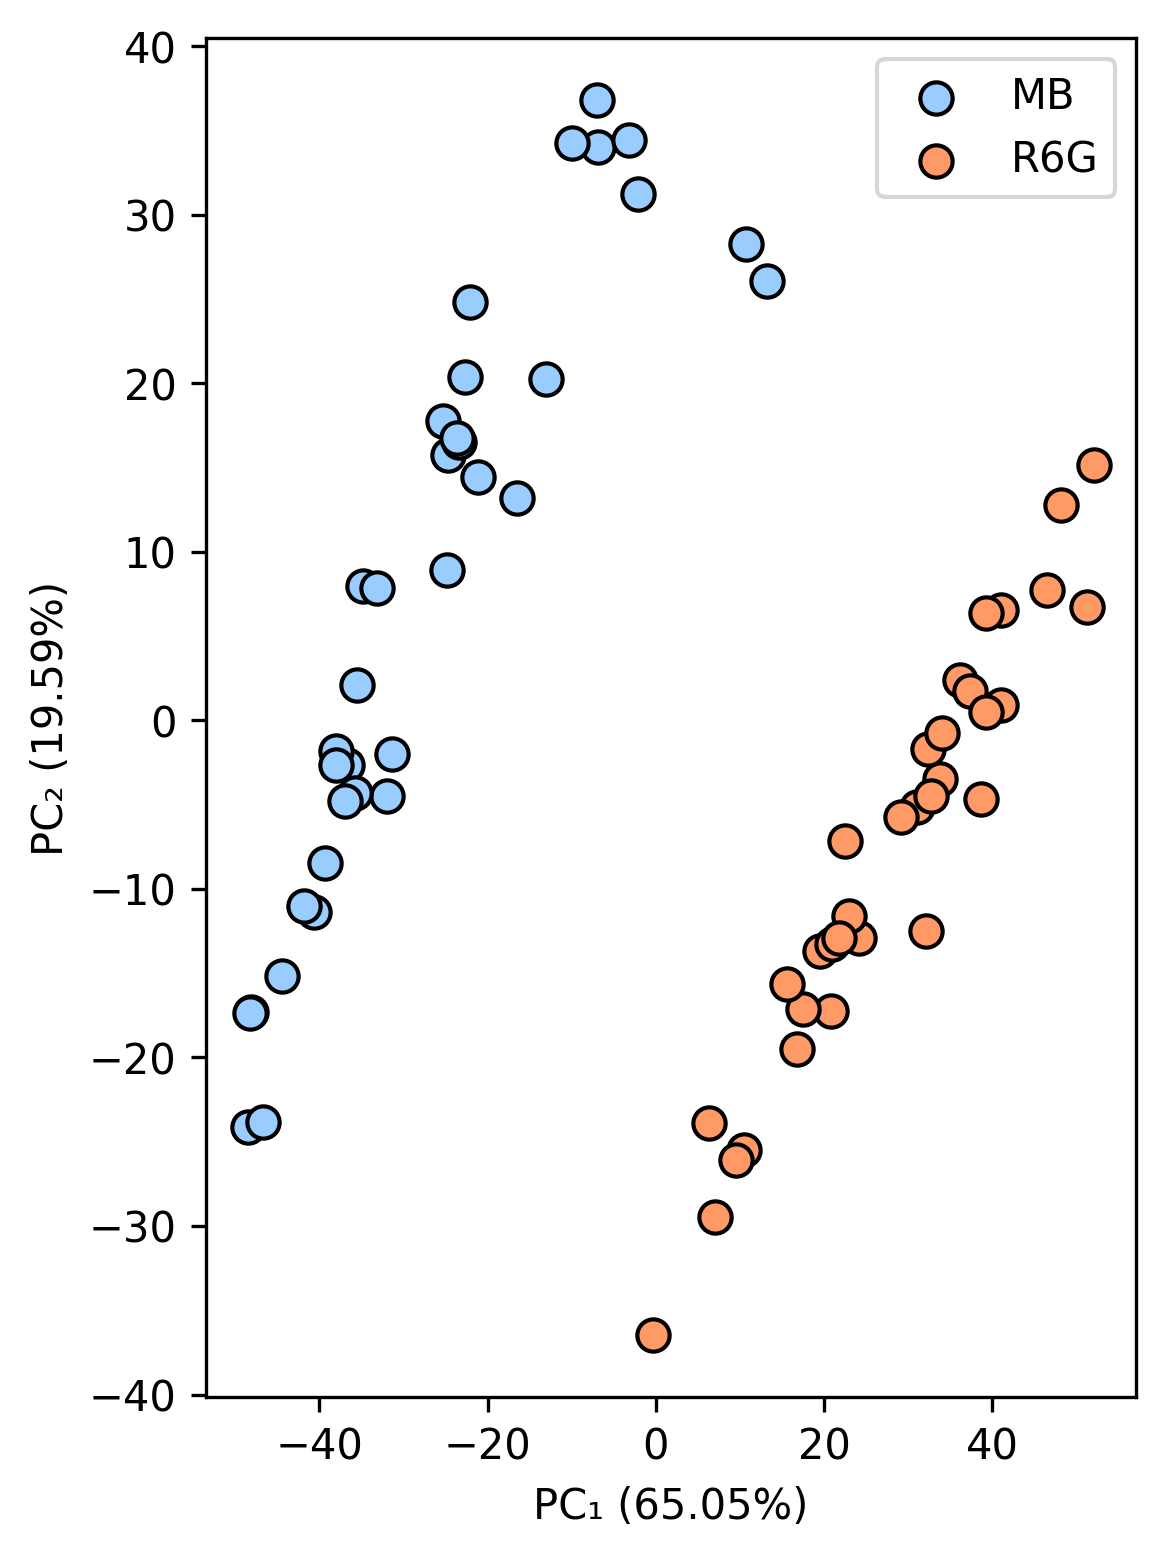

In [74]:
plot_pca(df_MB_R6G_PCA_norm, X, explained_variance, True, labelPlot, colors)

---

In [75]:
npca = PCA(n_components=PCs)
nfeat = StandardScaler().fit_transform(df_MB_R6G_1_1_PCA_norm)
X = npca.fit_transform(nfeat)

In [76]:
explained_variance = npca.explained_variance_ratio_
explained_variance

array([0.53006357, 0.13284564, 0.10553443, 0.04373625, 0.03245008,
       0.02087964])

In [77]:
df_MB_R6G_1_1_PCA_norm['label'] = 1
df_MB_R6G_1_1_PCA_norm = create_label(dfMBe_4_120min_05_norm, df_MB_R6G_1_1_PCA_norm, 2, 'MB', 'norm')
df_MB_R6G_1_1_PCA_norm = create_label(dfMB_R6G_1_1_120min_05_norm, df_MB_R6G_1_1_PCA_norm, 3, 'MB_R6G_', 'norm')

In [78]:
labelPlot = ['R6G',
             'MB',
             'MB & R6G (1:1)']
colors = ['#FF9966', '#99CCFF', '#4D4D4D']

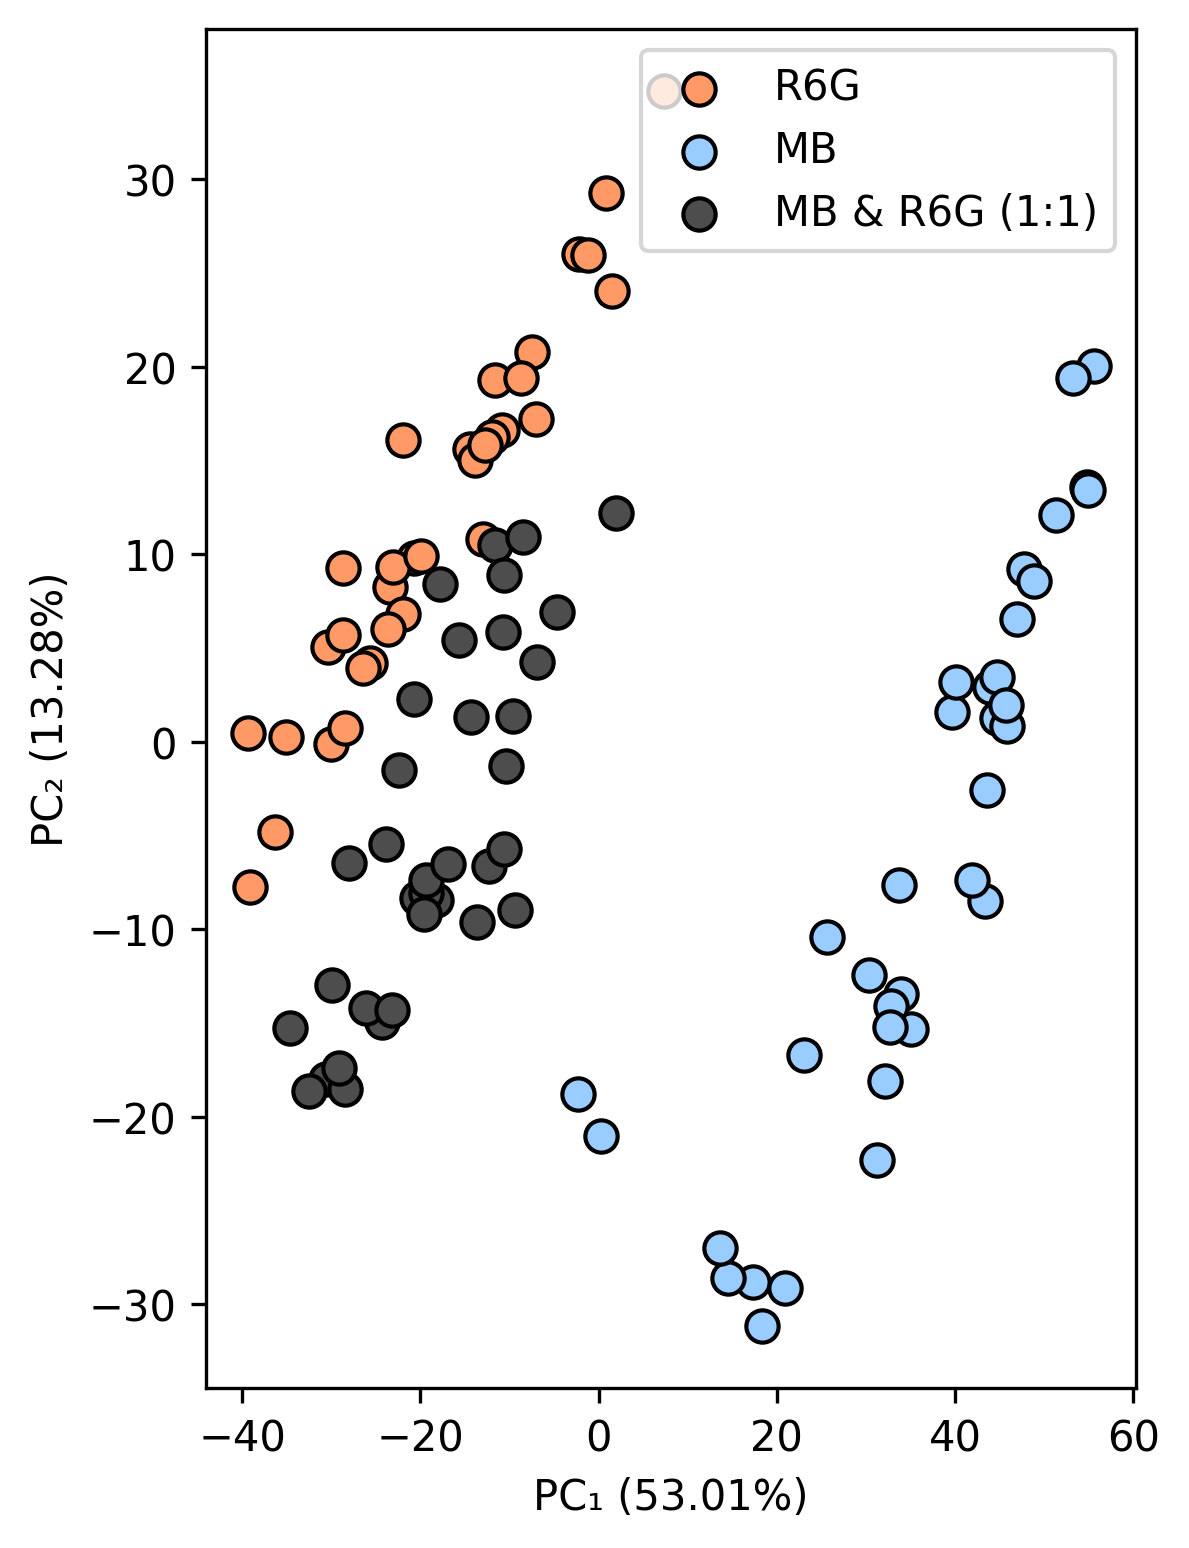

In [79]:
plot_pca(df_MB_R6G_1_1_PCA_norm, X, explained_variance, True, labelPlot, colors)

---

In [80]:
npca = PCA(n_components=PCs)
nfeat = StandardScaler().fit_transform(df_MB_R6G_1_2_PCA_norm)
X = npca.fit_transform(nfeat)

In [81]:
explained_variance = npca.explained_variance_ratio_
explained_variance

array([0.51866956, 0.18655754, 0.06591953, 0.03033472, 0.02793461,
       0.02105762])

In [82]:
df_MB_R6G_1_2_PCA_norm['label'] = 1
df_MB_R6G_1_2_PCA_norm = create_label(dfMBe_4_120min_05_norm, df_MB_R6G_1_2_PCA_norm, 2, 'MB', 'norm')
df_MB_R6G_1_2_PCA_norm = create_label(dfMB_R6G_1_2_120min_05_norm, df_MB_R6G_1_2_PCA_norm, 3, 'MB_R6G_', 'norm')

In [83]:
labelPlot = ['R6G',
             'MB',
             'MB & R6G (1:2)']
colors = ['#FF9966', '#99CCFF', '#4D4D4D']

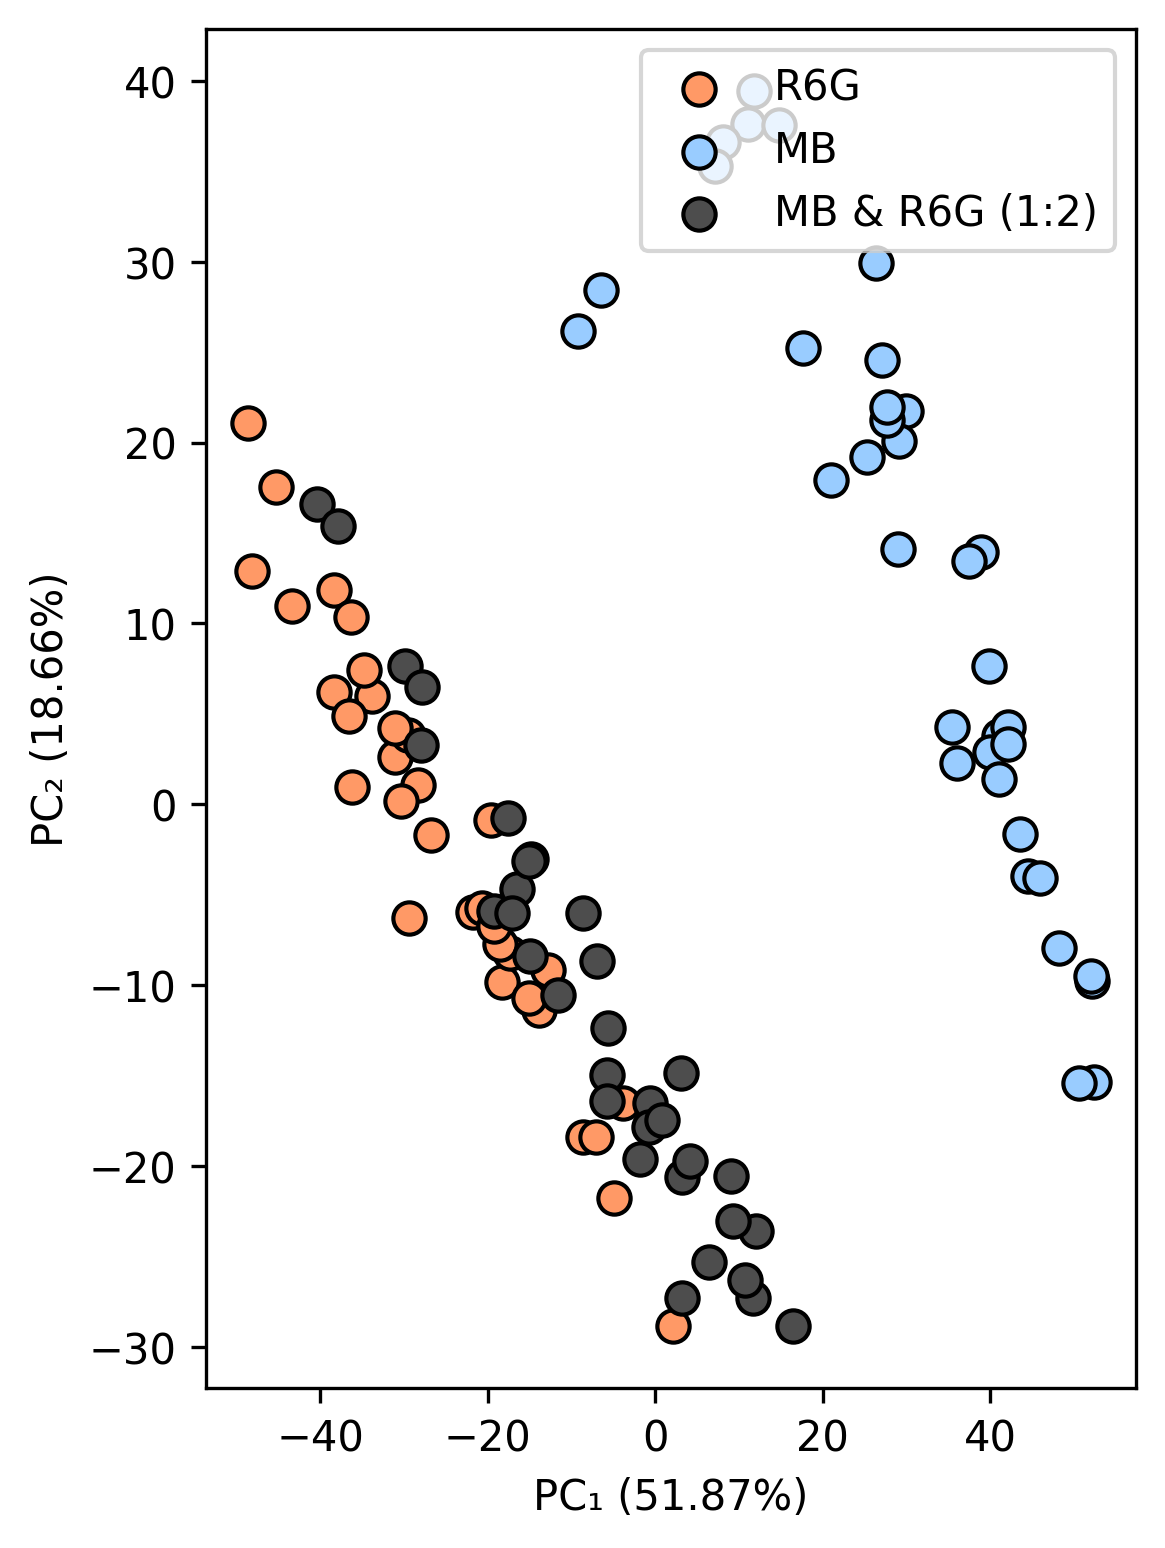

In [84]:
plot_pca(df_MB_R6G_1_2_PCA_norm, X, explained_variance, True, labelPlot, colors)

---

In [85]:
npca = PCA(n_components=PCs)
nfeat = StandardScaler().fit_transform(df_MB_R6G_1_3_PCA_norm)
X = npca.fit_transform(nfeat)

In [86]:
explained_variance = npca.explained_variance_ratio_
explained_variance

array([0.51271388, 0.18177337, 0.04995352, 0.02457106, 0.0199018 ,
       0.01513153])

In [87]:
df_MB_R6G_1_3_PCA_norm['label'] = 1
df_MB_R6G_1_3_PCA_norm = create_label(dfMBe_4_120min_05_norm, df_MB_R6G_1_3_PCA_norm, 2, 'MB', 'norm')
df_MB_R6G_1_3_PCA_norm = create_label(dfMB_R6G_1_3_120min_05_norm, df_MB_R6G_1_3_PCA_norm, 3, 'MB_R6G_', 'norm')

In [88]:
labelPlot = ['R6G',
             'MB',
             'MB & R6G (1:3)']
colors = ['#FF9966', '#99CCFF', '#4D4D4D']

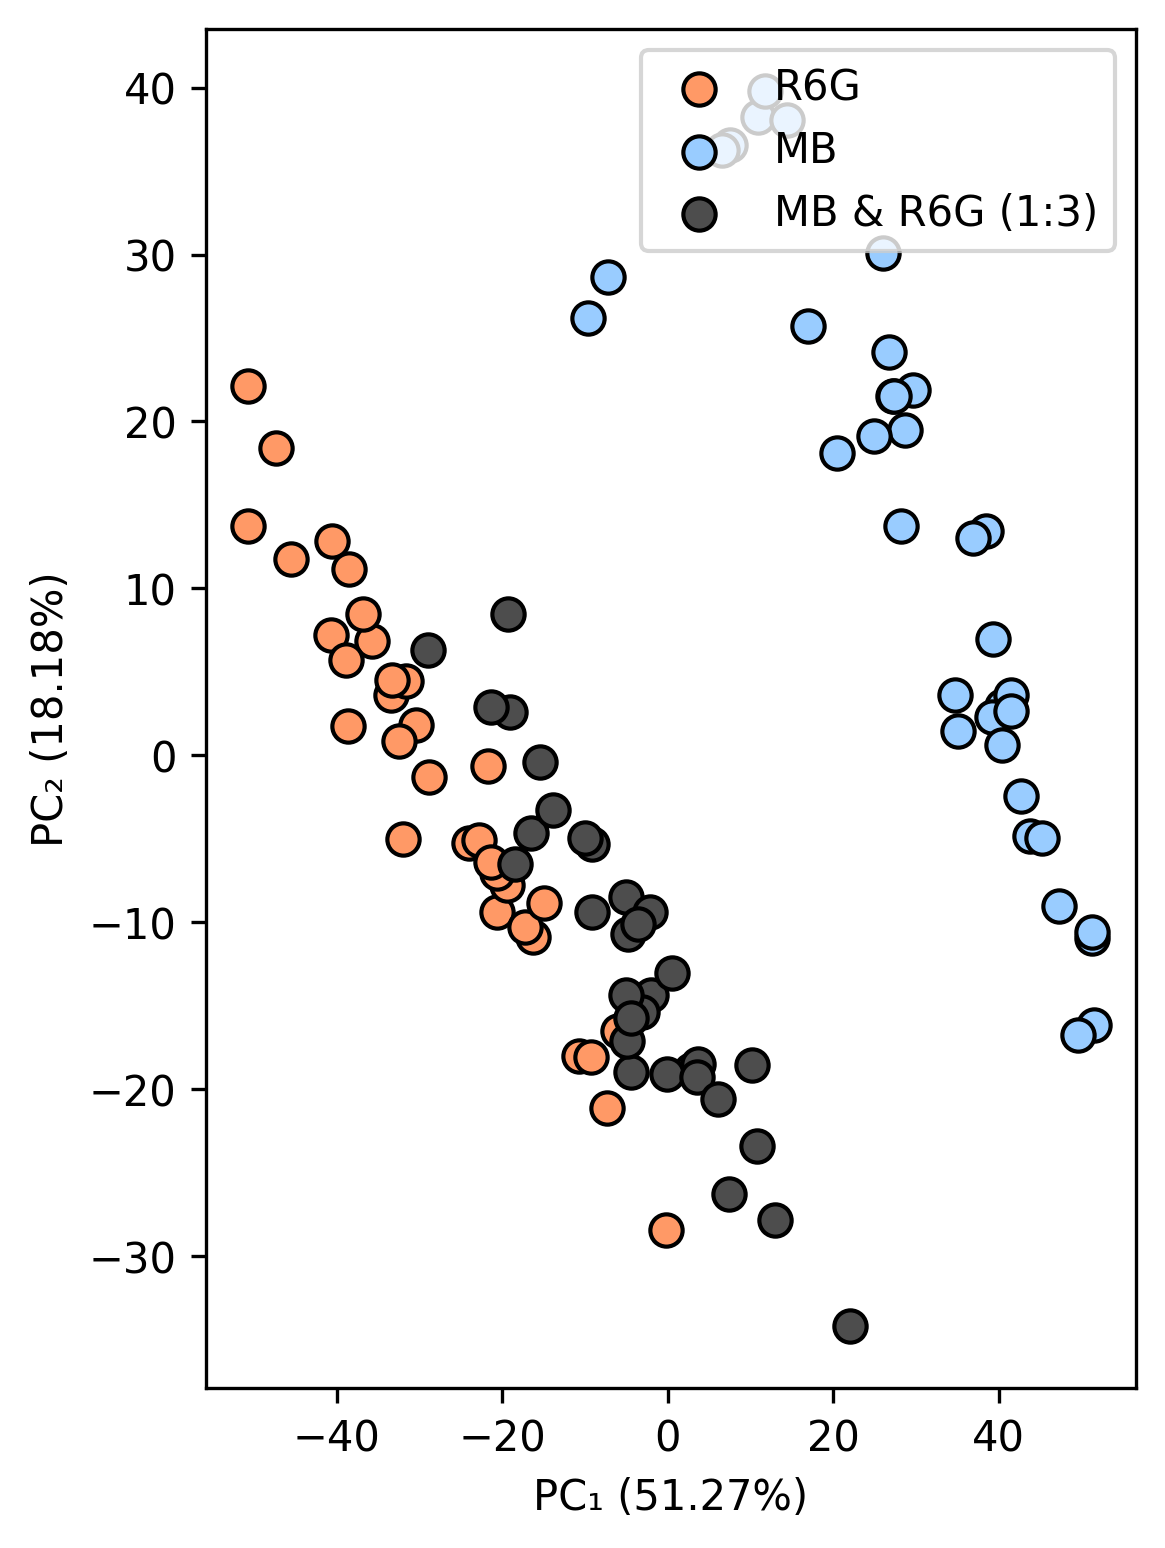

In [89]:
plot_pca(df_MB_R6G_1_3_PCA_norm, X, explained_variance, True, labelPlot, colors)

---

In [90]:
npca = PCA(n_components=PCs)
nfeat = StandardScaler().fit_transform(df_map1_PCA_norm)
X = npca.fit_transform(nfeat)

In [91]:
explained_variance = npca.explained_variance_ratio_
explained_variance

array([0.3663819 , 0.11950411, 0.1003566 , 0.04992054, 0.04183456,
       0.01826483])

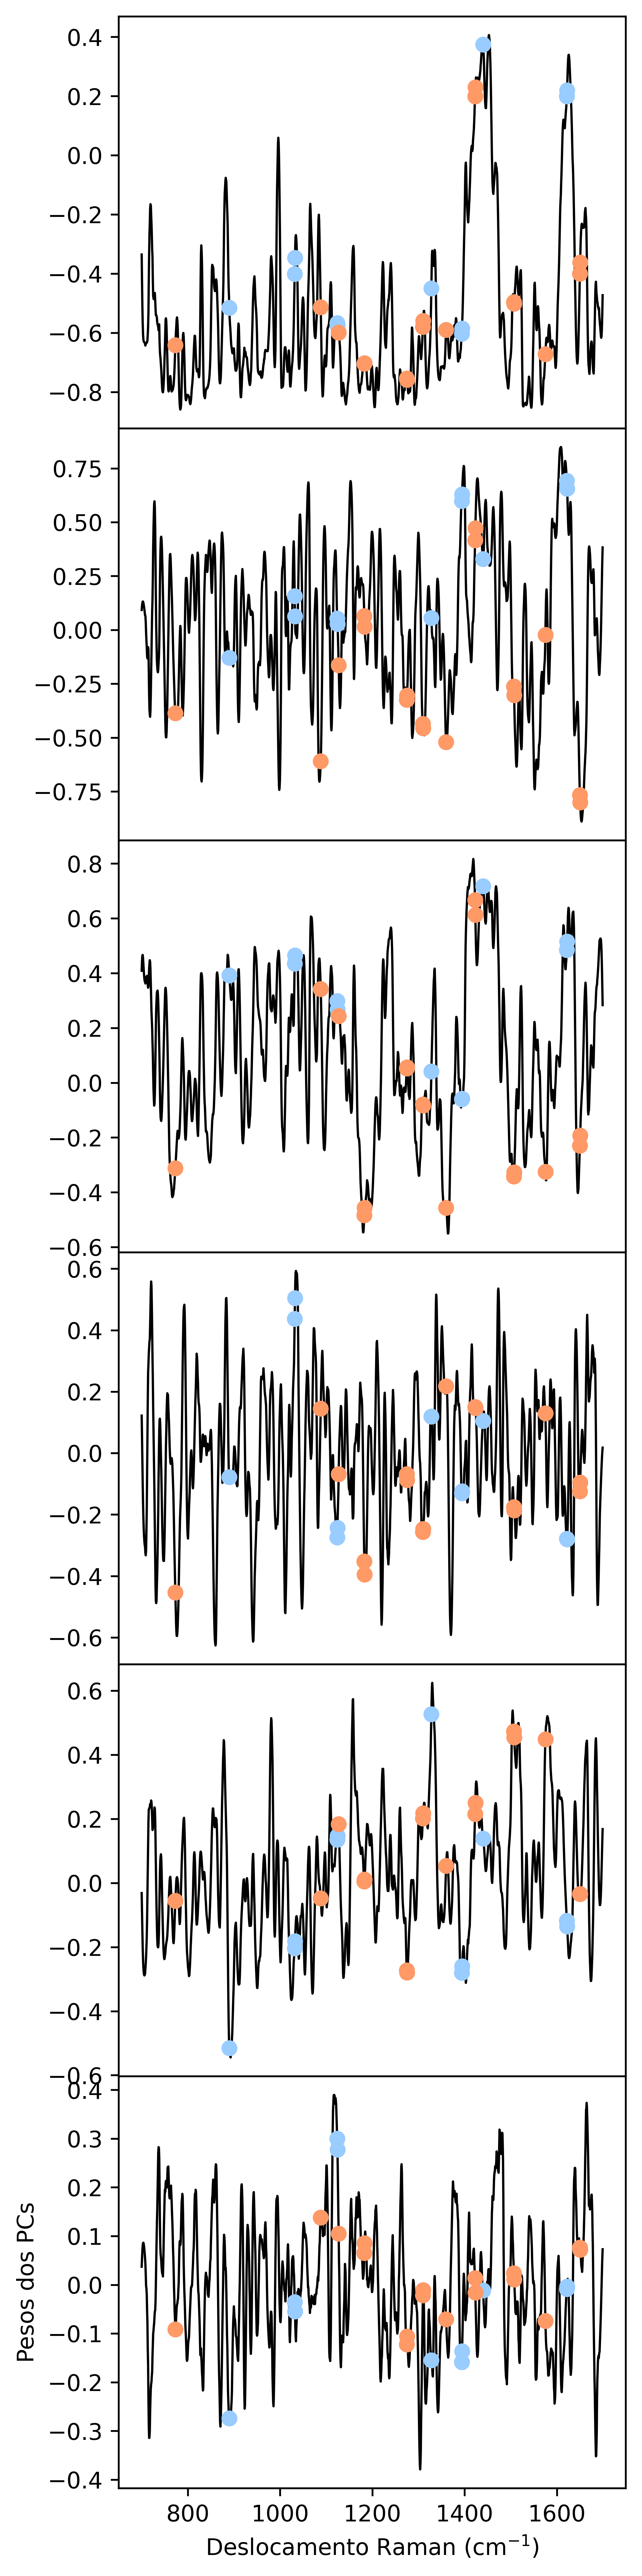

In [92]:
plot_n_loadings(dfMBe_4_120min_05_norm, npca, PCs, MB, R6G)

In [93]:
df_map1_PCA_norm['label'] = 1
df_map1_PCA_norm = create_label(dfMBe_4_120min_05_norm, df_map1_PCA_norm, 2, 'MB', 'norm')
df_map1_PCA_norm = create_label(dfR6Ge_4_120min_05_norm, df_map1_PCA_norm, 3, 'R6G', 'norm')

In [94]:
labelPlot = ['Mapa 1',
             'MB',
             'R6G']
colors = ['#969696', '#99CCFF', '#FF9966']

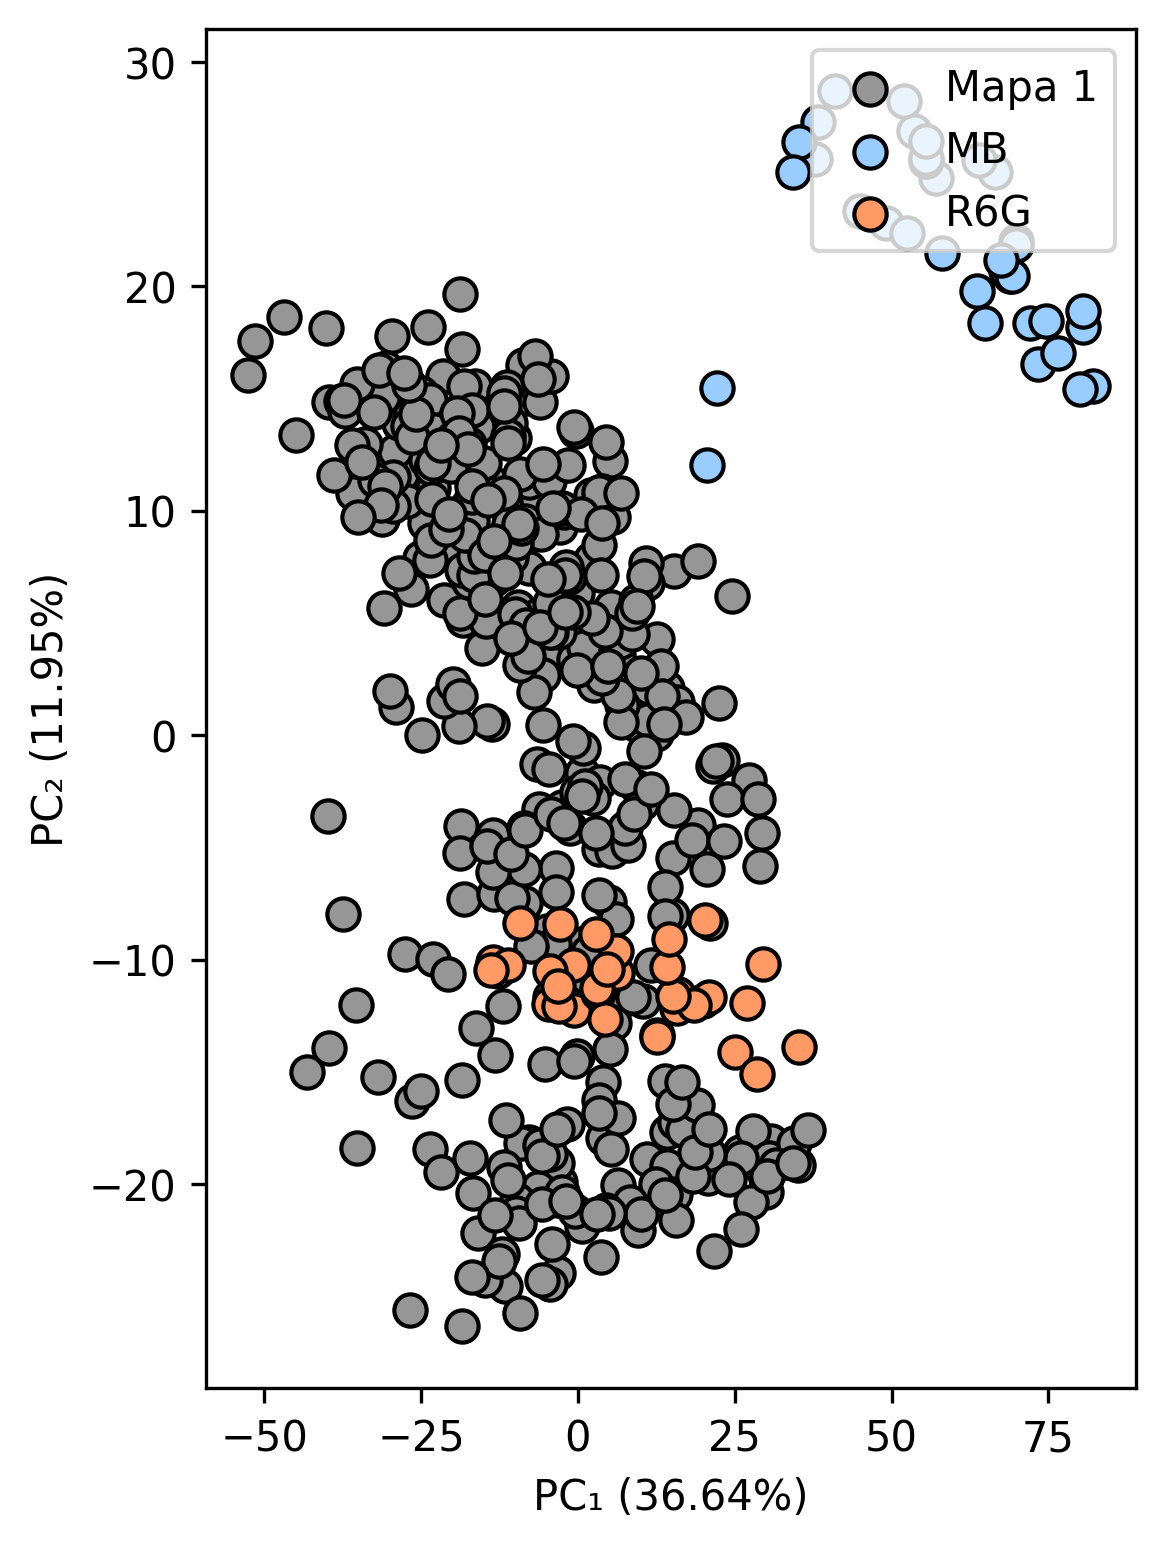

In [95]:
plot_pca(df_map1_PCA_norm, X, explained_variance, True, labelPlot, colors)

---

In [96]:
npca = PCA(n_components=PCs)
nfeat = StandardScaler().fit_transform(df_map2_PCA_norm)
X = npca.fit_transform(nfeat)

In [97]:
explained_variance = npca.explained_variance_ratio_
explained_variance

array([0.57802326, 0.07927569, 0.05954676, 0.05205719, 0.0244033 ,
       0.02268744])

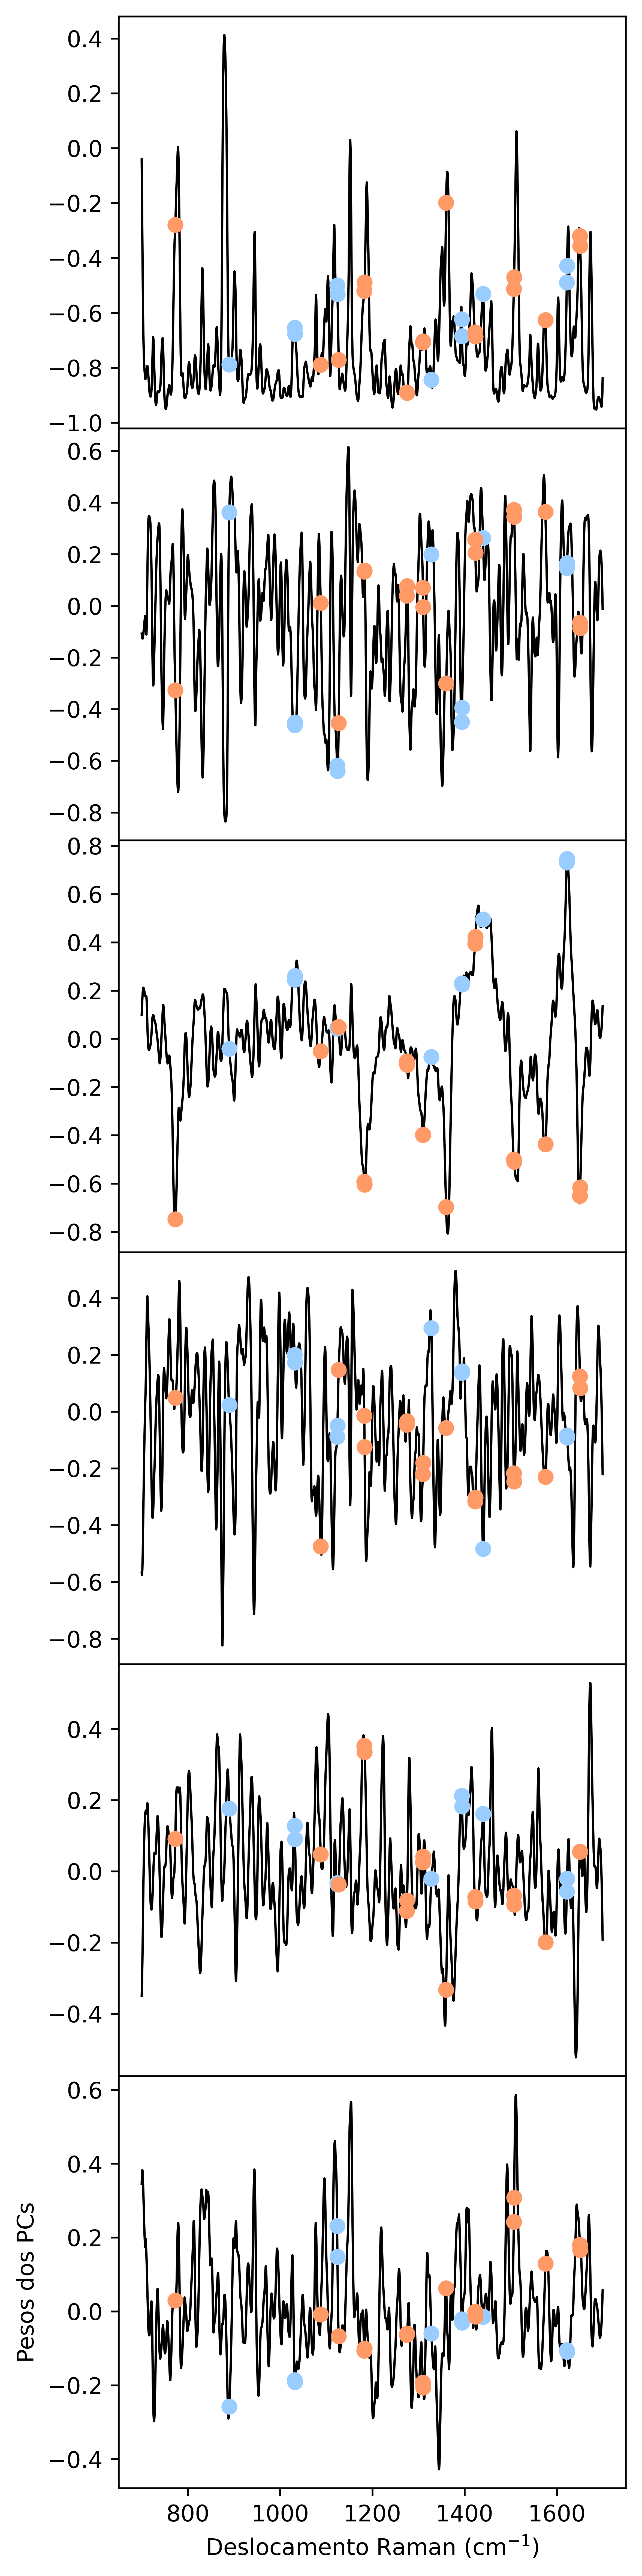

In [98]:
plot_n_loadings(dfMBe_4_120min_05_norm, npca, PCs, MB, R6G)

In [99]:
df_map2_PCA_norm['label'] = 1
df_map2_PCA_norm = create_label(dfMBe_4_120min_05_norm, df_map2_PCA_norm, 2, 'MB', 'norm')
df_map2_PCA_norm = create_label(dfR6Ge_4_120min_05_norm, df_map2_PCA_norm, 3, 'R6G', 'norm')

In [100]:
labelPlot = ['Mapa 2',
             'MB',
             'R6G']
colors = ['#4D4D4D', '#99CCFF', '#FF9966']

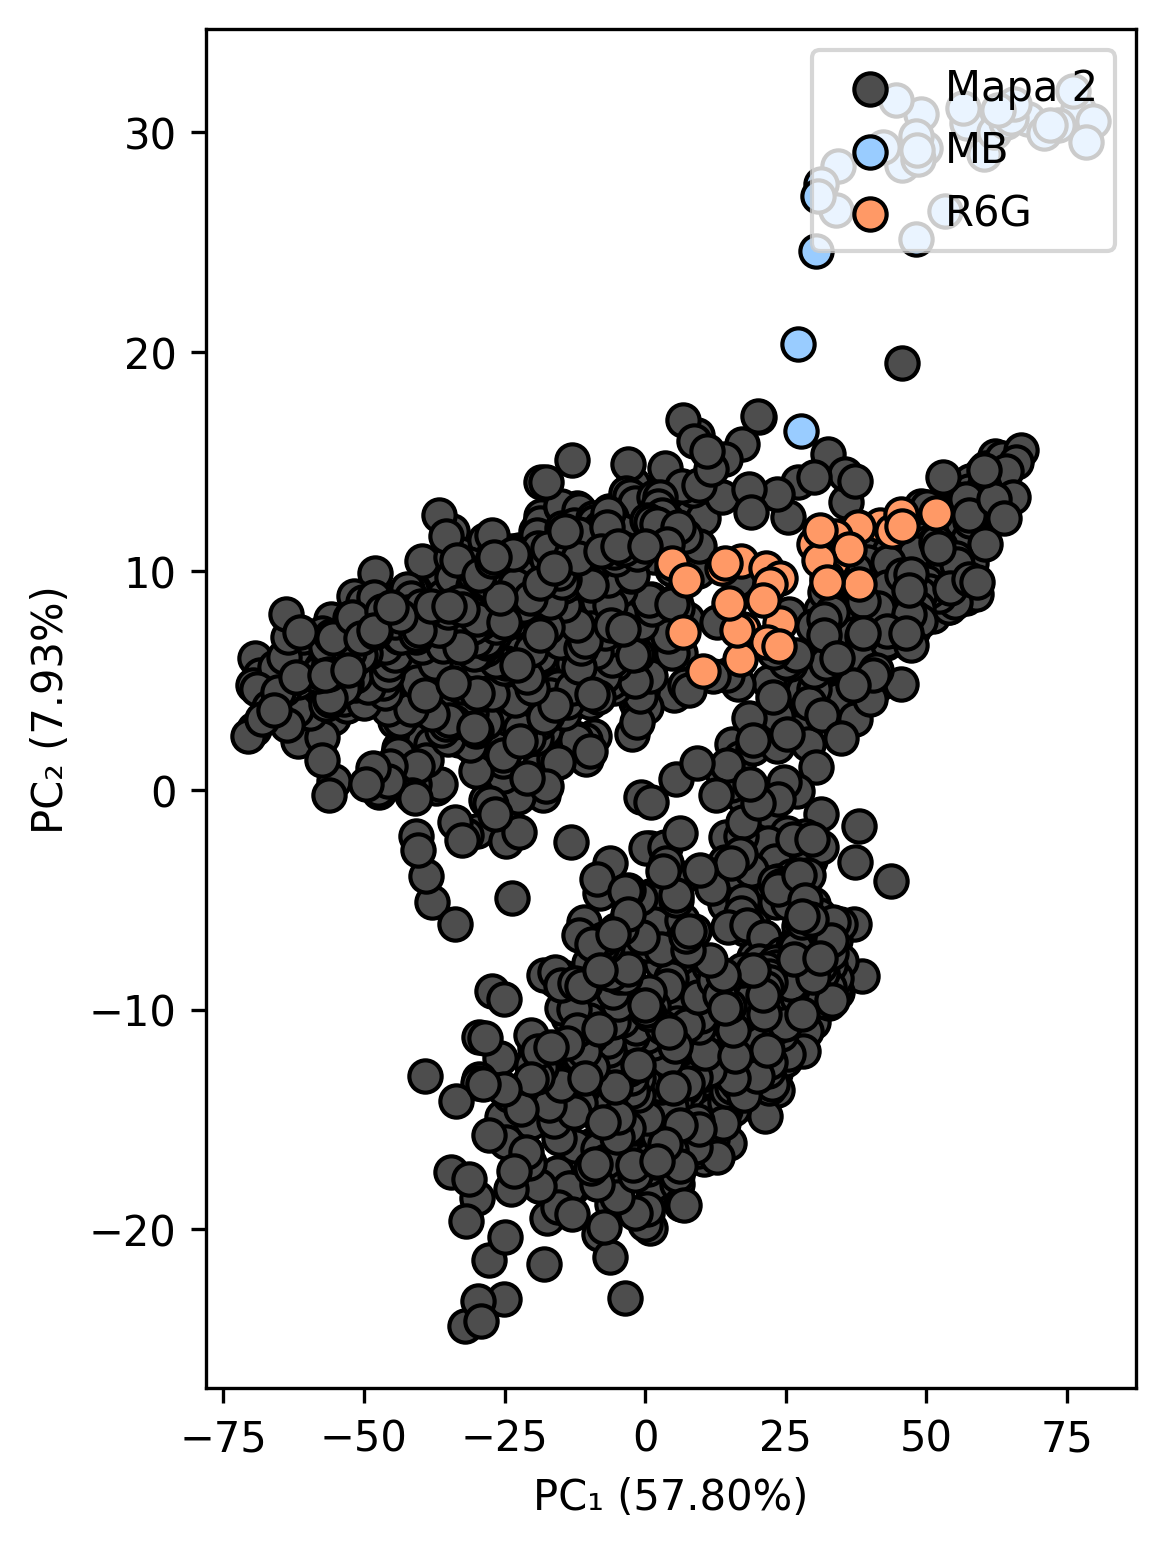

In [101]:
plot_pca(df_map2_PCA_norm, X, explained_variance, True, labelPlot, colors)

---

In [102]:
npca = PCA(n_components=6)
nfeat = StandardScaler().fit_transform(df_map1_PCA_1650_peak)
X = npca.fit_transform(nfeat)

In [103]:
explained_variance = npca.explained_variance_ratio_
explained_variance

array([0.445622  , 0.11725889, 0.09980354, 0.06268804, 0.05171374,
       0.04221317])

In [104]:
df_map1_PCA_1650_peak['label'] = 1

In [105]:
spectra = ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010',
           '0011', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023',
           '0024', '0025', '0026', '0027', '0040', '0041', '0042', '0043', '0147', '0168']
df_map1_PCA_1650_peak = create_label_spectrum(df_map1_PCA_1650_peak, 2, 'MB_R6G_1', spectra, 'sg')

In [106]:
spectra = ['0055', '0056', '0076', '0115', '0120', '0199', '0200', '0290', '0291', '0292',
           '0293', '0294', '0295', '0296', '0297', '0298', '0299', '0300', '0430', '0431',
           '0432', '0433', '0434', '0435', '0436', '0437', '0438', '0439', '0440', '0441']
df_map1_PCA_1650_peak = create_label_spectrum(df_map1_PCA_1650_peak, 3, 'MB_R6G_1', spectra, 'sg')

In [107]:
labelPlot = ['Mapa 1',
             'SERS',
             'Sem SERS']
colors = ['#07FBF6', '#6B8E23', '#900020']

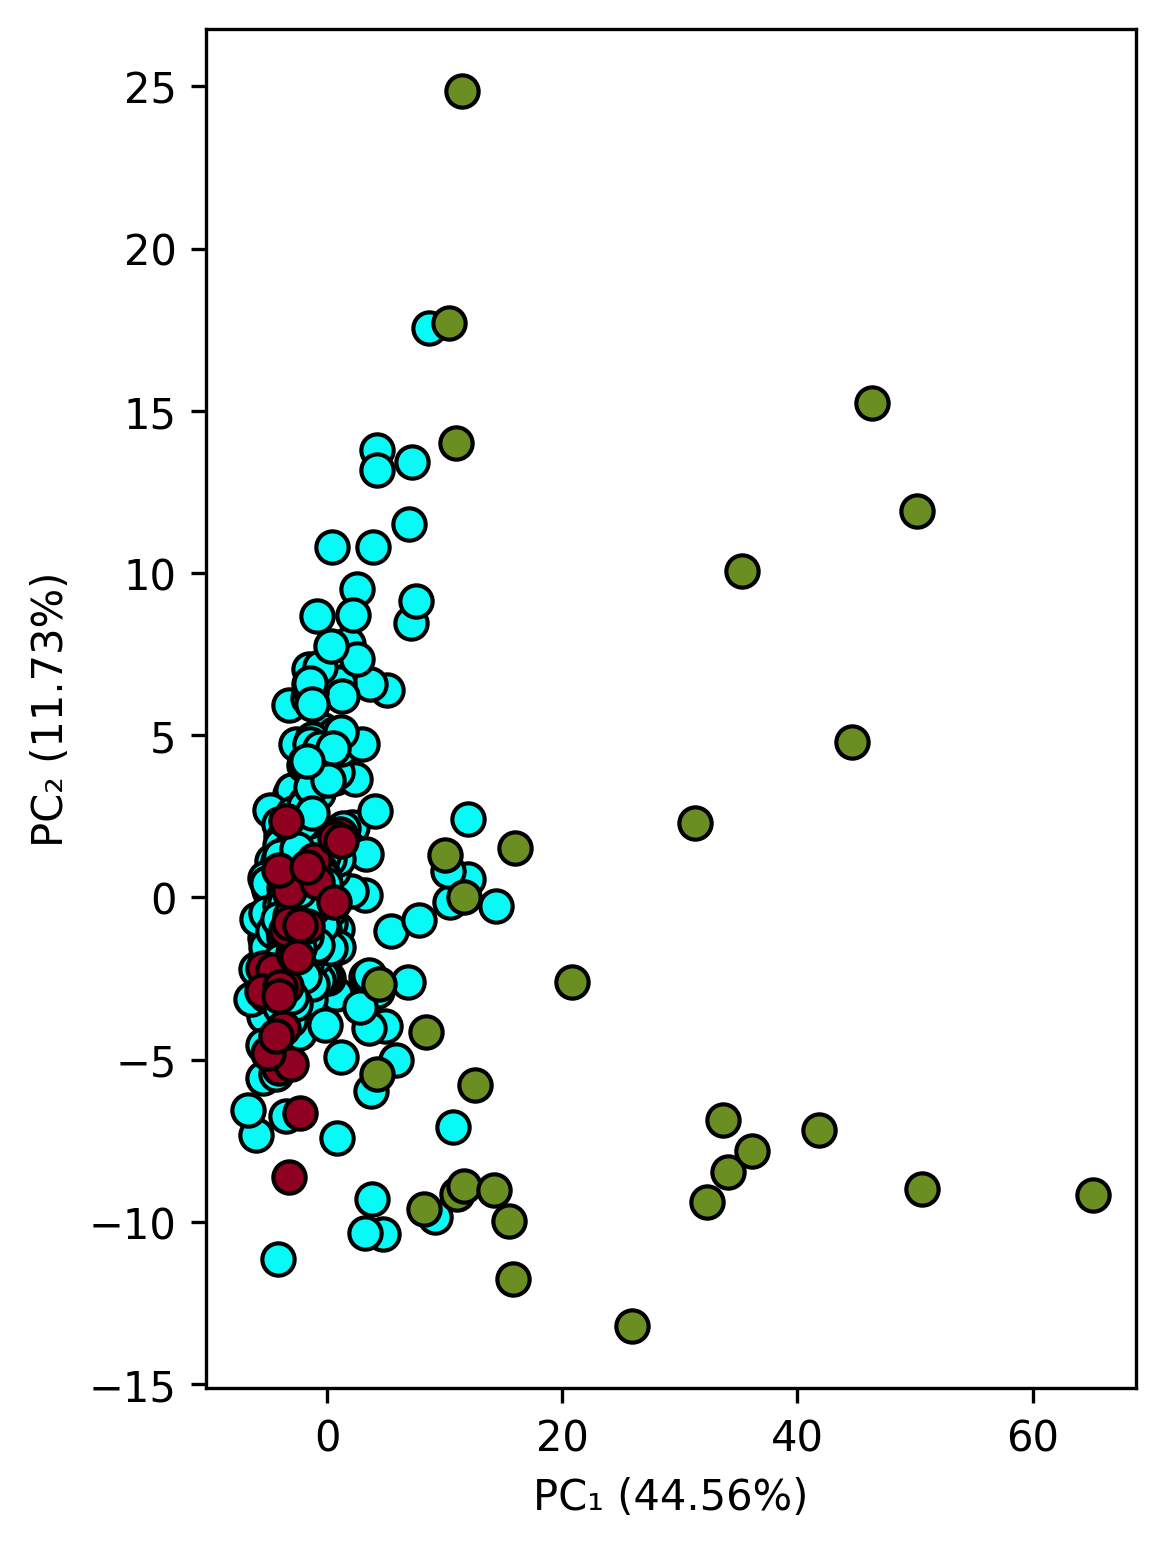

In [108]:
plot_pca(df_map1_PCA_1650_peak, X, explained_variance, False, labelPlot, colors)

In [109]:
df_sum = df_map1_PCA_1650_peak.sum(axis = 1)

In [110]:
df_sum[df_map1_PCA_1650_peak.index[df_map1_PCA_1650_peak['label'] == 2]]

07espectro0001sgMB_R6G_1    6059.534269
07espectro0002sgMB_R6G_1    5021.991318
07espectro0003sgMB_R6G_1    4241.330075
07espectro0004sgMB_R6G_1    3533.943443
07espectro0005sgMB_R6G_1    3720.984080
07espectro0006sgMB_R6G_1    3781.006317
07espectro0007sgMB_R6G_1    3640.313560
07espectro0008sgMB_R6G_1    2989.980955
07espectro0009sgMB_R6G_1    2160.756045
07espectro0010sgMB_R6G_1    1423.813930
07espectro0011sgMB_R6G_1    1114.423810
07espectro0015sgMB_R6G_1    1125.591089
07espectro0016sgMB_R6G_1    1878.624177
07espectro0017sgMB_R6G_1    3405.852468
07espectro0018sgMB_R6G_1    4130.519540
07espectro0019sgMB_R6G_1    4175.480597
07espectro0020sgMB_R6G_1    3452.329279
07espectro0021sgMB_R6G_1    2879.004670
07espectro0022sgMB_R6G_1    2114.551952
07espectro0023sgMB_R6G_1    1943.444315
07espectro0024sgMB_R6G_1    1521.410125
07espectro0025sgMB_R6G_1    1612.459104
07espectro0026sgMB_R6G_1    1215.941370
07espectro0027sgMB_R6G_1    1694.652398
07espectro0040sgMB_R6G_1    1670.246138


In [111]:
df_sum[df_map1_PCA_1650_peak.index[df_map1_PCA_1650_peak['label'] == 3]]

07espectro0055sgMB_R6G_1    420.029534
07espectro0056sgMB_R6G_1    333.614297
07espectro0076sgMB_R6G_1    294.758085
07espectro0115sgMB_R6G_1    354.004500
07espectro0120sgMB_R6G_1    548.074928
07espectro0199sgMB_R6G_1    424.059033
07espectro0200sgMB_R6G_1    506.066981
07espectro0290sgMB_R6G_1    689.359258
07espectro0291sgMB_R6G_1    633.470789
07espectro0292sgMB_R6G_1    686.757650
07espectro0293sgMB_R6G_1    715.549025
07espectro0294sgMB_R6G_1    713.392125
07espectro0295sgMB_R6G_1    446.034351
07espectro0296sgMB_R6G_1    507.828347
07espectro0297sgMB_R6G_1    490.230784
07espectro0298sgMB_R6G_1    508.761188
07espectro0299sgMB_R6G_1    619.931644
07espectro0300sgMB_R6G_1    466.648336
07espectro0430sgMB_R6G_1    450.310572
07espectro0431sgMB_R6G_1    374.594328
07espectro0432sgMB_R6G_1    549.973672
07espectro0433sgMB_R6G_1    698.206189
07espectro0434sgMB_R6G_1    587.053412
07espectro0435sgMB_R6G_1    502.352683
07espectro0436sgMB_R6G_1    557.597267
07espectro0437sgMB_R6G_1 

In [112]:
df_verify = pd.DataFrame(df_sum.gt(1100), columns=['GT'])
gt = df_verify.index[df_verify['GT']].tolist()

In [113]:
rows = df_map1_PCA_1650_peak.index.intersection(gt)

In [114]:
df_map1_PCA_1650_peak['label'] = 1

row = df_map1_PCA_1650_peak.index

for row in rows:
    df_map1_PCA_1650_peak['label'][row] = 2

In [115]:
labelPlot = ['< 1000 u.a.',
             '> 1000 u.a.']
colors = ['#969696', '#07FBF6']

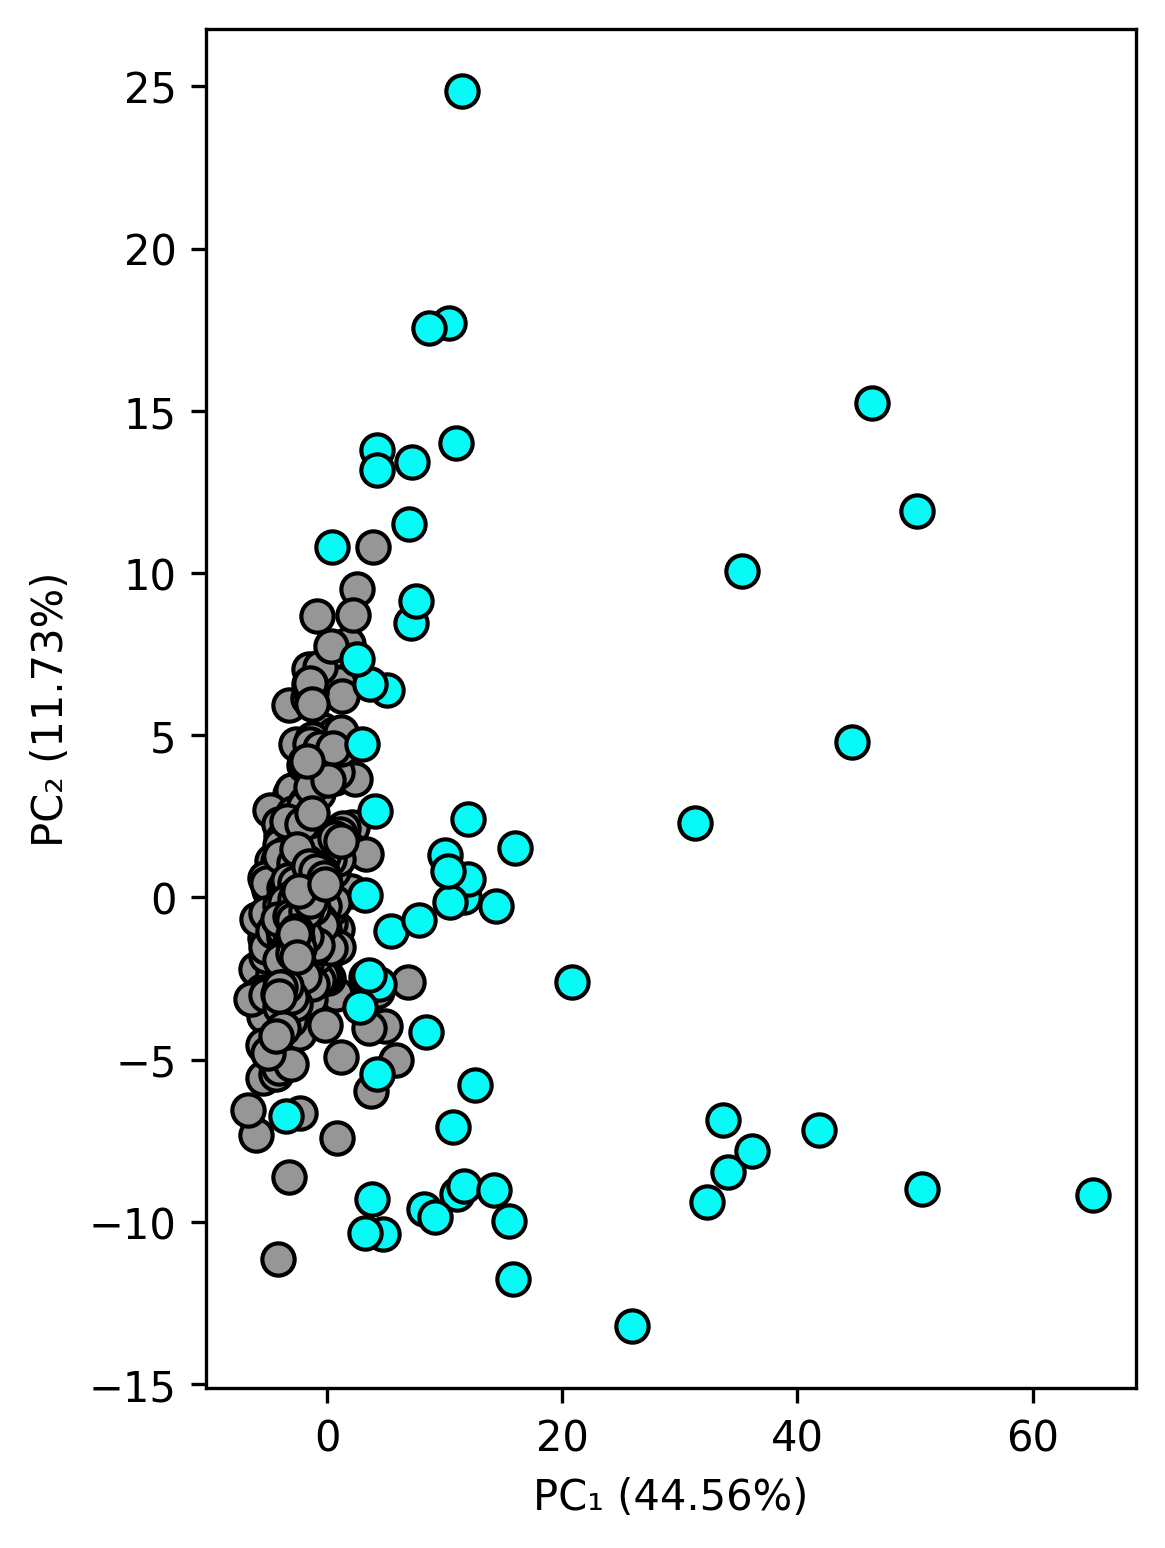

In [116]:
plot_pca(df_map1_PCA_1650_peak, X, explained_variance, False, labelPlot, colors)

In [117]:
regex = '[0-9]{2}(espectro[0-9]{4}sg)*'
match = [re.search(regex, row).group(1) for row in rows]

sers = pd.DataFrame(dfMB_R6G_1_3_120min_07_1_peak['numero de onda'], columns=['numero de onda'])
sers[match] = dfMB_R6G_1_3_120min_07_1_peak.filter(regex='|'.join(match))
plot(sers, 'sg')

In [118]:
df_temp = df_sum[df_map1_PCA_1650_peak.index.isin(rows)]
df_temp.std()/df_temp.mean()

0.5624016277917568

In [119]:
rows.size/df_map1_PCA_1650_peak.shape[0]

0.13378684807256236

---

In [120]:
npca = PCA(n_components=6)
nfeat = StandardScaler().fit_transform(df_map2_PCA_1650_peak)
X = npca.fit_transform(nfeat)

In [121]:
explained_variance = npca.explained_variance_ratio_
explained_variance

array([0.26628785, 0.19407103, 0.1548205 , 0.08909306, 0.06112276,
       0.04566329])

In [122]:
df_map2_PCA_1650_peak['label'] = 1

In [123]:
spectra = ['0003', '0004', '0005', '0006', '0007', '0024', '0025', '0026', '0027', '0028',
           '0029', '0030', '0031', '0032', '0033', '0034', '0035', '0036', '0037', '0038',
           '0039', '0040', '0041', '0081', '0164', '0689', '0690', '0731', '0775', '0816']
df_map2_PCA_1650_peak = create_label_spectrum(df_map2_PCA_1650_peak, 2, 'MB_R6G_2', spectra, 'sg')

In [124]:
spectra = ['0261', '0262', '0263', '0264', '0265', '0303', '0304', '0305', '0306', '0672',
           '0673', '0674', '1436', '1437', '1438', '1439', '1440', '1441', '1442', '1443',
           '1444', '1445', '1480', '1481', '1482', '1483', '1484', '1485', '1486', '1487']
df_map2_PCA_1650_peak = create_label_spectrum(df_map2_PCA_1650_peak, 3, 'MB_R6G_2', spectra, 'sg')

In [125]:
labelPlot = ['Mapa 2',
             'SERS',
             'Sem SERS']
colors = ['#07FBF6', '#6B8E23', '#900020']

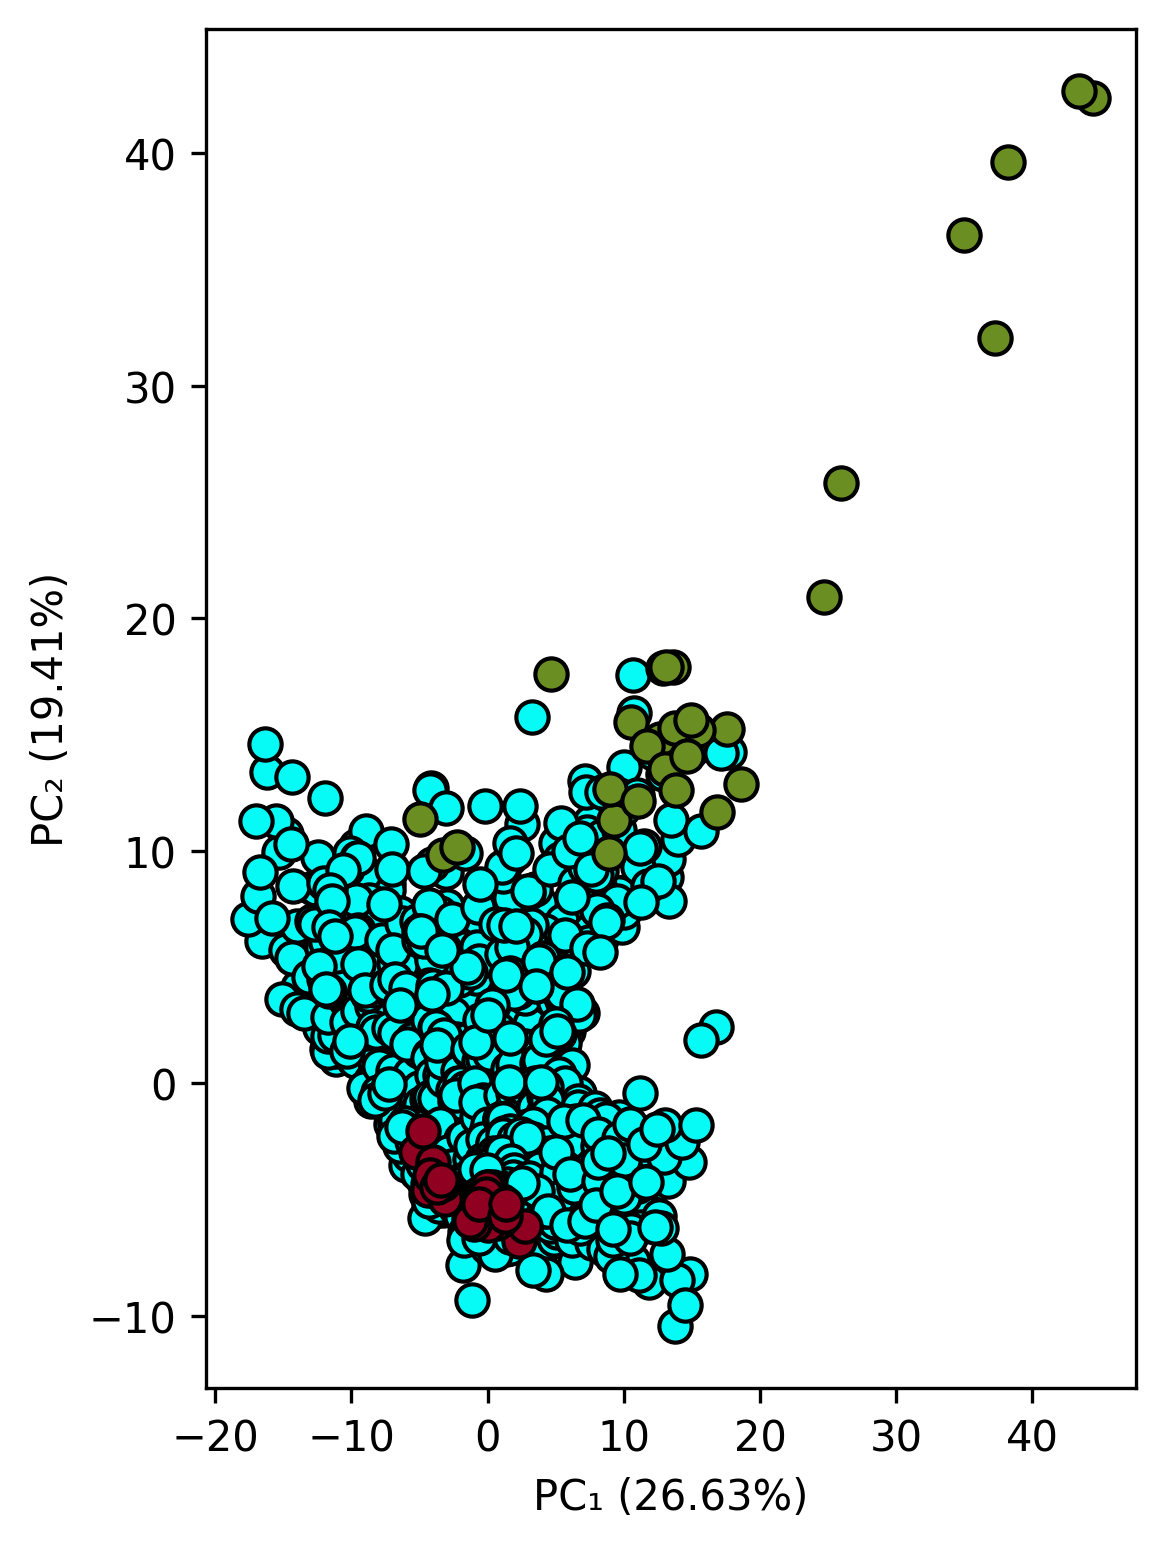

In [126]:
plot_pca(df_map2_PCA_1650_peak, X, explained_variance, False, labelPlot, colors)

In [127]:
df_sum = df_map2_PCA_1650_peak.sum(axis = 1)

In [128]:
df_sum[df_map2_PCA_1650_peak.index[df_map2_PCA_1650_peak['label'] == 2]]

07espectro0003sgMB_R6G_2     4734.607440
07espectro0004sgMB_R6G_2     4937.605773
07espectro0005sgMB_R6G_2     4923.443429
07espectro0006sgMB_R6G_2     4715.246257
07espectro0007sgMB_R6G_2     4438.969158
07espectro0024sgMB_R6G_2     3841.033613
07espectro0025sgMB_R6G_2     3833.389741
07espectro0026sgMB_R6G_2     3875.273168
07espectro0027sgMB_R6G_2     4279.381283
07espectro0028sgMB_R6G_2     4279.413181
07espectro0029sgMB_R6G_2     4886.532137
07espectro0030sgMB_R6G_2     4946.402782
07espectro0031sgMB_R6G_2     5005.554189
07espectro0032sgMB_R6G_2     4239.331763
07espectro0033sgMB_R6G_2     4817.932347
07espectro0034sgMB_R6G_2     6895.380434
07espectro0035sgMB_R6G_2     9720.041630
07espectro0036sgMB_R6G_2    11238.533445
07espectro0037sgMB_R6G_2    10372.918286
07espectro0038sgMB_R6G_2     8928.775222
07espectro0039sgMB_R6G_2     8127.691709
07espectro0040sgMB_R6G_2     6495.335585
07espectro0041sgMB_R6G_2     3790.184581
07espectro0081sgMB_R6G_2     3069.052360
07espectro0164sg

In [129]:
df_sum[df_map2_PCA_1650_peak.index[df_map2_PCA_1650_peak['label'] == 3]]

07espectro0261sgMB_R6G_2     763.343317
07espectro0262sgMB_R6G_2     614.800917
07espectro0263sgMB_R6G_2     511.105617
07espectro0264sgMB_R6G_2     748.913100
07espectro0265sgMB_R6G_2     742.353615
07espectro0303sgMB_R6G_2     332.052128
07espectro0304sgMB_R6G_2     485.905245
07espectro0305sgMB_R6G_2     600.500514
07espectro0306sgMB_R6G_2     745.441431
07espectro0672sgMB_R6G_2     485.849954
07espectro0673sgMB_R6G_2     517.100180
07espectro0674sgMB_R6G_2     561.226872
07espectro1436sgMB_R6G_2    1124.338718
07espectro1437sgMB_R6G_2     926.500145
07espectro1438sgMB_R6G_2     936.970425
07espectro1439sgMB_R6G_2     907.648644
07espectro1440sgMB_R6G_2     814.714303
07espectro1441sgMB_R6G_2     751.954233
07espectro1442sgMB_R6G_2     844.446744
07espectro1443sgMB_R6G_2     642.599943
07espectro1444sgMB_R6G_2     811.095829
07espectro1445sgMB_R6G_2     682.953130
07espectro1480sgMB_R6G_2     837.986236
07espectro1481sgMB_R6G_2     747.612041
07espectro1482sgMB_R6G_2     694.210368


In [130]:
df_verify = pd.DataFrame(df_sum.gt(2900), columns=['GT'])
gt = df_verify.index[df_verify['GT']].tolist()

In [131]:
rows = df_map2_PCA_1650_peak.index.intersection(gt)

In [132]:
df_map2_PCA_1650_peak['label'] = 1

row = df_map2_PCA_1650_peak.index

for row in rows:
    df_map2_PCA_1650_peak['label'][row] = 2

In [133]:
labelPlot = ['< 2900 u.a.',
             '> 2900 u.a.']
colors = ['#969696', '#07FBF6']

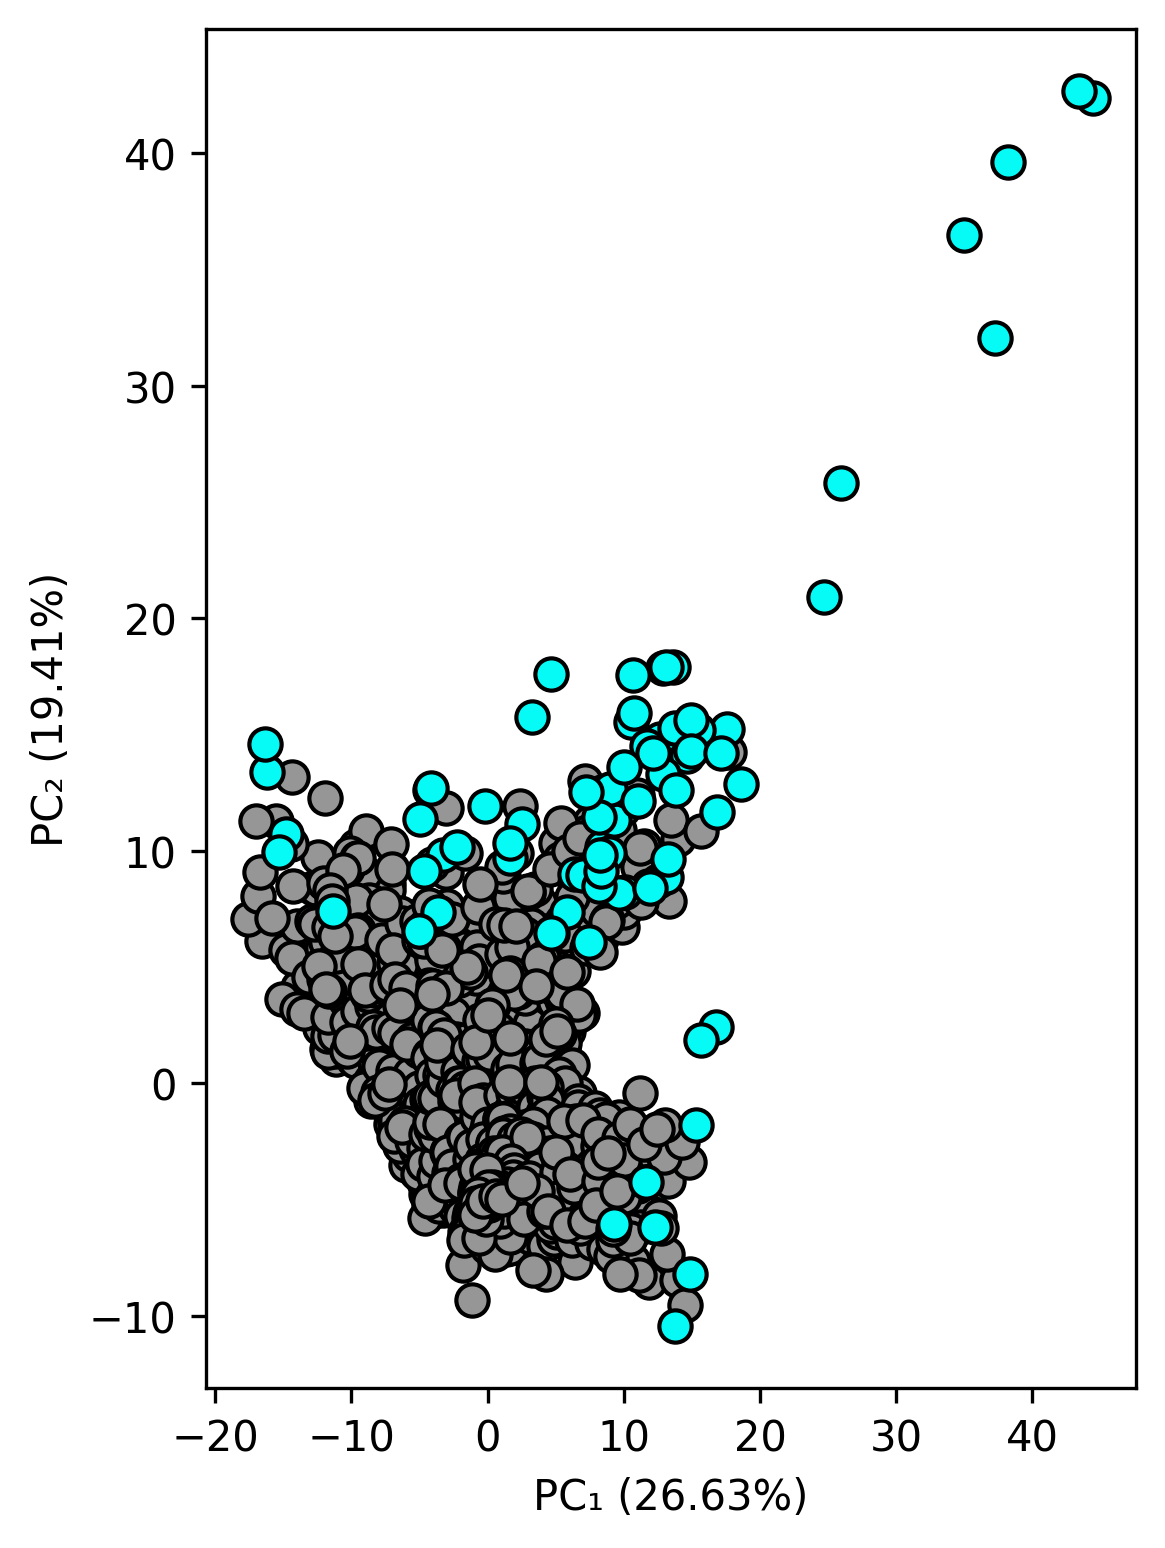

In [134]:
plot_pca(df_map2_PCA_1650_peak, X, explained_variance, False, labelPlot, colors)

In [135]:
regex = '[0-9]{2}(espectro[0-9]{4}sg)*'
match = [re.search(regex, row).group(1) for row in rows]

sers = pd.DataFrame(dfMB_R6G_1_3_120min_07_2_peak['numero de onda'], columns=['numero de onda'])
sers[match] = dfMB_R6G_1_3_120min_07_2_peak.filter(regex='|'.join(match))
plot(sers, 'sg')

In [136]:
df_temp = df_sum[df_map2_PCA_1650_peak.index.isin(rows)]
df_temp.std()/df_temp.mean()

0.4176325901541572

In [137]:
rows.size/df_map2_PCA_1650_peak.shape[0]

0.045211183819155266

#### Classificação

* **Pós _PCA_**

In [138]:
X = df_MB_R6G_04_05_PCA_norm.drop('label', 1)
y = df_MB_R6G_04_05_PCA_norm['label'].astype('int')

O conjunto de dados foi dividido em 80% de dados de treinamento e 20% de dados de teste para validação do modelo treinado. O parâmetro `random_state` mantém a mesma divisão de teste a cada compilação, e o seu número inicial não precisa ser 42, mas qualquer número.

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [140]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [141]:
pca = PCA(n_components=6)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [142]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.55891044, 0.18079581, 0.03991509, 0.03078764, 0.01949517,
       0.01589097])

In [143]:
dfMB_R6G_1_3_120min_1_PCA_norm = preprocessed_dataframe(dfMB_R6G_1_3_120min_07_1_norm, 'norm')
dfMB_R6G_1_3_120min_2_PCA_norm = preprocessed_dataframe(dfMB_R6G_1_3_120min_07_2_norm, 'norm')
dfMB_R6G_1_3_120min_PCA_norm = preprocessed_dataframe(dfMB_R6G_1_3_120min_05_norm, 'norm')

In [144]:
X_mix_1_3 = sc.transform(dfMB_R6G_1_3_120min_PCA_norm)
X_mix_1_3 = pca.transform(X_mix_1_3)

In [145]:
X_mix_1_3_1 = sc.transform(dfMB_R6G_1_3_120min_1_PCA_norm)
X_mix_1_3_1 = pca.transform(X_mix_1_3_1)

In [146]:
X_mix_1_3_2 = sc.transform(dfMB_R6G_1_3_120min_2_PCA_norm)
X_mix_1_3_2 = pca.transform(X_mix_1_3_2)

* _Isolation Forest_
* _Support Vector Machines_

Para treinar o modelo _One-Class Support Vector Machines_, os hiperparâmetros que devem ser definidos são:
1. `nu` especifica a percentagem de anomalias (`nu=0.01` significa que 1% dos valores do conjunto de dados são discrepantes);

2. `kernel` especifica o tipo de Kernel. A função de base radial (rbf) é comumente usado, e mapeia dados de um espaço de baixa dimensão para um espaço de alta dimensão para ajudar o modelo a traçar um limite de decisão;

3. `gamma`, um coeficiente de Kernel para `rbf`, `poly` e `sigmoid`. Ao configurá-lo em `auto`, o coeficiente do Kernel é 1 sobre o número de recursos.

* _Minimum Covariance Determinant_

In [147]:
#MB
X_occ_MB_train = X_train[y_train != 2]
y_occ_MB_train = y_train[y_train != 2]

X_occ_MB_test = X_test[y_test != 2]
y_occ_MB_test = y_test[y_test != 2]

X_occ_MB = X[y != 2]
y_occ_MB = y[y != 2]
X_occ_MB = sc.fit_transform(X_occ_MB)
X_occ_MB = pca.fit_transform(X_occ_MB)

In [148]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.5870392 , 0.1101248 , 0.0550242 , 0.04768518, 0.02840933,
       0.02452392])

In [149]:
y_occ_MB_validation = y[y != 2]
y_occ_MB_validation[y_occ_MB_validation == 1] = -1

In [150]:
#R6G
#MB
X_occ_R6G_train = X_train[y_train != 1]
y_occ_R6G_train = y_train[y_train != 1]
y_occ_R6G_train[y_occ_R6G_train == 2] = 1

X_occ_R6G_test = X_test[y_test != 1]
y_occ_R6G_test = y_test[y_test != 1]
y_occ_R6G_test[y_occ_R6G_test == 2] = 1

X_occ_R6G = X[y != 1]
y_occ_R6G = y[y != 1]
y_occ_R6G[y_occ_R6G == 2] = 1
X_occ_R6G = sc.fit_transform(X_occ_R6G)
X_occ_R6G = pca.fit_transform(X_occ_R6G)

In [151]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.41163557, 0.12971699, 0.05249549, 0.03877366, 0.03527765,
       0.03336977])

In [152]:
y_occ_R6G_validation = y[y != 1]
y_occ_R6G_validation[y_occ_R6G_validation == 2] = -1

In [153]:
c = 0.2
classifiers = {
    "Isolation Forest":IsolationForest(max_samples=30, contamination=c, random_state=1),
    "SVM":OneClassSVM(kernel='linear', nu=0.01),
    "Minimum Covariance Determinant":EllipticEnvelope(contamination=c, random_state=1)}

In [154]:
X_MB = np.append(X_occ_R6G, X_occ_MB_test, axis=0)
y_MB = np.append(y_occ_R6G_validation, y_occ_MB_test, axis=0)

In [155]:
for i,(model_name, model) in enumerate(classifiers.items()):
    model = model.fit(X_occ_MB_train)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_occ_MB_train, y_occ_MB_train, cv=kf, scoring='accuracy')
    print("Scores:", scores)
    print("Média das pontuações:", np.mean(scores))
    print("Desvio padrão das pontuações:", np.std(scores))
    print('')
    
    print('\033[1m' + model_name + '\033[0m')
    y_pred = model.predict(X_MB)
    print(classification_report(y_MB, y_pred))
    validation(y_MB, y_pred)
    
    if model_name != "Minimum Covariance Determinant":
        print('')

Scores: [0.875      0.5        0.71428571 0.71428571 0.85714286]
Média das pontuações: 0.7321428571428572
Desvio padrão das pontuações: 0.13458174058154834

Isolation Forest
              precision    recall  f1-score   support

          -1       0.95      0.36      0.52        50
           1       0.22      0.90      0.35        10

    accuracy                           0.45        60
   macro avg       0.58      0.63      0.44        60
weighted avg       0.83      0.45      0.49        60

[[18 32]
 [ 1  9]]
Acurácia 0.45
Precisão 0.21951219512195122
Sensibilidade 0.9

Scores: [0.75       0.875      1.         0.85714286 0.85714286]
Média das pontuações: 0.8678571428571429
Desvio padrão das pontuações: 0.07953949089757174

SVM
              precision    recall  f1-score   support

          -1       0.98      0.80      0.88        50
           1       0.47      0.90      0.62        10

    accuracy                           0.82        60
   macro avg       0.72      0.85      

In [156]:
X_R6G = np.append(X_occ_MB, X_occ_R6G_test, axis=0)
y_R6G = np.append(y_occ_MB_validation, y_occ_R6G_test, axis=0)

In [157]:
for i,(model_name, model) in enumerate(classifiers.items()):
    model.fit(X_occ_R6G_train)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_occ_R6G_train, y_occ_R6G_train, cv=kf, scoring='accuracy')
    print("Scores:", scores)
    print("Média das pontuações:", np.mean(scores))
    print("Desvio padrão das pontuações:", np.std(scores))
    print('')
    
    print('\033[1m' + model_name + '\033[0m')
    y_pred = model.predict(X_R6G)
    print(classification_report(y_R6G, y_pred))
    validation(y_R6G, y_pred)
    
    if model_name != "Minimum Covariance Determinant":
        print('')

Scores: [0.75  0.875 0.75  0.875 0.375]
Média das pontuações: 0.725
Desvio padrão das pontuações: 0.18371173070873836

Isolation Forest
              precision    recall  f1-score   support

          -1       0.94      0.64      0.76        47
           1       0.32      0.80      0.46        10

    accuracy                           0.67        57
   macro avg       0.63      0.72      0.61        57
weighted avg       0.83      0.67      0.71        57

[[30 17]
 [ 2  8]]
Acurácia 0.6666666666666666
Precisão 0.32
Sensibilidade 0.8

Scores: [1.    0.875 1.    0.875 0.875]
Média das pontuações: 0.925
Desvio padrão das pontuações: 0.06123724356957946

SVM
              precision    recall  f1-score   support

          -1       1.00      0.70      0.82        47
           1       0.42      1.00      0.59        10

    accuracy                           0.75        57
   macro avg       0.71      0.85      0.71        57
weighted avg       0.90      0.75      0.78        57

[[33 14

---

In [193]:
pred_1 = pd.DataFrame()
pred_2 = pd.DataFrame()
pred_3 = pd.DataFrame()

In [266]:
model = EllipticEnvelope(contamination=0.1, random_state=1)
model.fit(X_occ_MB)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_occ_MB, y_occ_MB, cv=kf, scoring='accuracy')
print("Scores:", scores)
print("Média das pontuações:", np.mean(scores))
print("Desvio padrão das pontuações:", np.std(scores))

y_pred = model.predict(X_mix_1_3_1)
pred_1['MB'] = y_pred
print("Mapa 1", classification_report(np.ones((X_mix_1_3_1.shape[0]), dtype=int), y_pred))
validation(np.ones((X_mix_1_3_1.shape[0]), dtype=int), y_pred)

y_pred = model.predict(X_mix_1_3_2)
pred_2['MB'] = y_pred
print("Mapa 2", classification_report(np.ones((X_mix_1_3_2.shape[0]), dtype=int), y_pred))
validation(np.ones((X_mix_1_3_2.shape[0]), dtype=int), y_pred)
                  
y_pred = model.predict(X_mix_1_3)
pred_3['MB'] = y_pred
print("1:3", classification_report(np.ones((X_mix_1_3.shape[0]), dtype=int), y_pred))
validation(np.ones((X_mix_1_3.shape[0]), dtype=int), y_pred)

Scores: [1.         0.6        1.         1.         0.88888889]
Média das pontuações: 0.8977777777777778
Desvio padrão das pontuações: 0.15498307354811286
Mapa 1               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.58      0.73       441

    accuracy                           0.58       441
   macro avg       0.50      0.29      0.37       441
weighted avg       1.00      0.58      0.73       441

[[  0   0]
 [185 256]]
Acurácia 0.5804988662131519
Precisão 1.0
Sensibilidade 0.5804988662131519
Mapa 2               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.39      0.56      1681

    accuracy                           0.39      1681
   macro avg       0.50      0.19      0.28      1681
weighted avg       1.00      0.39      0.56      1681

[[   0    0]
 [1033  648]]
Acurácia 0.3854848304580607
Precisão 1.0
Sensibilida

In [195]:
model = EllipticEnvelope(contamination=0.1, random_state=1)
model.fit(X_occ_R6G)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_occ_R6G, y_occ_R6G, cv=kf, scoring='accuracy')
print("Scores:", scores)
print("Média das pontuações:", np.mean(scores))
print("Desvio padrão das pontuações:", np.std(scores))

y_pred = model.predict(X_mix_1_3_1)
pred_1['R6G'] = y_pred
print("Mapa 1", classification_report(np.ones((X_mix_1_3_1.shape[0]), dtype=int), y_pred))
validation(np.ones((X_mix_1_3_1.shape[0]), dtype=int), y_pred)

y_pred = model.predict(X_mix_1_3_2)
pred_2['R6G'] = y_pred
print("Mapa 2", classification_report(np.ones((X_mix_1_3_2.shape[0]), dtype=int), y_pred))
validation(np.ones((X_mix_1_3_2.shape[0]), dtype=int), y_pred)

y_pred = model.predict(X_mix_1_3)
pred_3['R6G'] = y_pred
print("1:3", classification_report(np.ones((X_mix_1_3.shape[0]), dtype=int), y_pred))
validation(np.ones((X_mix_1_3.shape[0]), dtype=int), y_pred)

Scores: [1.  0.9 0.8 0.7 1. ]
Média das pontuações: 0.8800000000000001
Desvio padrão das pontuações: 0.11661903789690602
Mapa 1               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.98      0.99       441

    accuracy                           0.98       441
   macro avg       0.50      0.49      0.50       441
weighted avg       1.00      0.98      0.99       441

[[  0   0]
 [  8 433]]
Acurácia 0.981859410430839
Precisão 1.0
Sensibilidade 0.981859410430839
Mapa 2               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.86      0.93      1681

    accuracy                           0.86      1681
   macro avg       0.50      0.43      0.46      1681
weighted avg       1.00      0.86      0.93      1681

[[   0    0]
 [ 233 1448]]
Acurácia 0.8613920285544319
Precisão 1.0
Sensibilidade 0.8613920285544319
1:3            

In [230]:
selecao = pred_1.query('MB == R6G')
equal = len(selecao)
selecao = pred_1.loc[pred_1['MB'] == 1]
print(len(selecao)/equal)
print(equal/len(pred_1))

0.9696969696969697
0.5986394557823129


In [231]:
selecao = pred_2.query('MB == R6G')
equal = len(selecao)
selecao = pred_2.loc[pred_2['MB'] == 1]
print(len(selecao)/equal)
print(equal/len(pred_2))

0.735527809307605
0.5240928019036288


In [232]:
selecao = pred_3.query('MB == R6G')
equal = len(selecao)
selecao = pred_3.loc[pred_3['MB'] == 1]
print(len(selecao)/equal)
print(equal/len(pred_3))

1.0
0.9375
